In [1]:
#acknowledgements
#this comparative model pipeline was built based on the pipeline by Christophe Pere
#the dependencies class_metric.py and custom_preprocessing.py are also from this repository
#https://github.com/Christophe-pere/Text-classification

In [2]:
%matplotlib inline
#load prerequisites
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

import sklearn
sklearn.__version__
from sklearn.utils import class_weight
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import neighbors
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import zero_one_loss
from sklearn.metrics import explained_variance_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

import seaborn as sns
import re
import itertools
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import text_to_word_sequence
from googletrans import Translator
import time
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import random
import stanza
from random import sample
from custom_preprocessing import CustomPreProcessing
from custom_preprocessing import PreProcessing
from class_metric import Metrics

import itertools
from textblob import TextBlob 
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
sns.set(style="darkgrid")
import string
import fasttext
import fasttext.util
from tqdm.notebook import tqdm

Using TensorFlow backend.
C:\Users\tabbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\tabbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\tabbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\tabbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [3]:
#set appropriate labels for each class
TEXT = "text"
LABEL = "verdict"

In [4]:
preprocess = CustomPreProcessing()
preproc = PreProcessing()
Metric = Metrics()

In [5]:
#load dataset
df = pd.read_csv("processed_dataset.csv", index_col=0)

In [ ]:
df_save = df.copy()
df = df.sample(frac=1, random_state=69)

In [7]:
#set language
language="en"

In [8]:
#find out some statistics such as characters and words per dataset entry 
df['char_count'] = df[TEXT].apply(len)
df['word_count'] = df[TEXT].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1) # Density of word (in char)

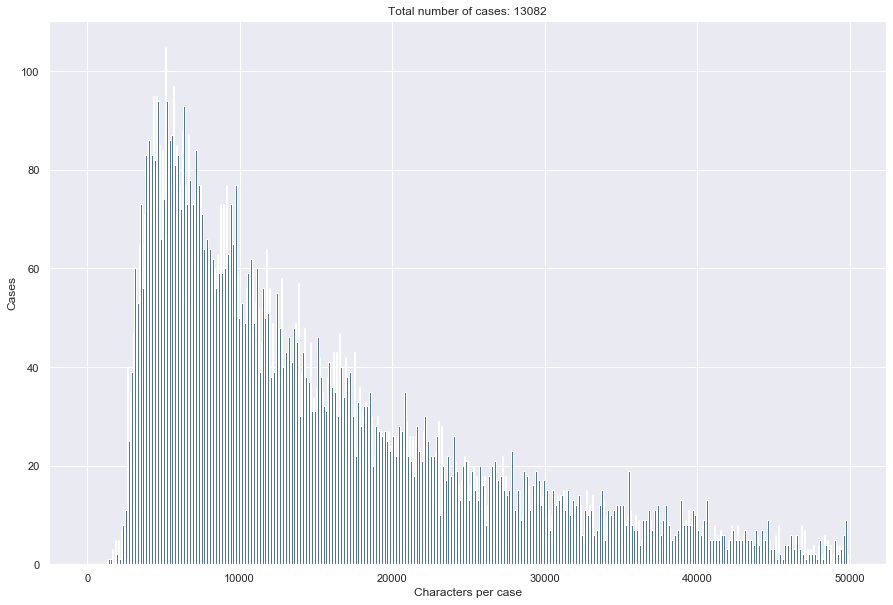

<Figure size 432x288 with 0 Axes>

In [9]:
#amount of characters per doc
plt.figure(figsize=(15,10))
max_x = 50000 if df.char_count.max()>10000 else df.char_count.max()
plt.hist(df.char_count.values, bins = range(0, max_x, 100))
plt.title(f"Total number of cases: {df.shape[0]}")
plt.xlabel("Characters per case")
plt.ylabel("Cases")
plt.grid(True)
plt.show()
plt.savefig("numb_char.jpg")

In [10]:
#rename data for subsequent models
df.loc[:,TEXT+"_sw"] = df.loc[:,TEXT]

In [11]:
if df[TEXT+"_sw"].isnull().sum()>0:
    print("Empty text")
    df[TEXT+"_sw"][df[TEXT+"_sw"].isnull()] = "empty_text"

In [12]:
# split the dataset into training and test datasets 
from sklearn.model_selection import train_test_split

train_x_sw, valid_x_sw, y_train_sw, y_valid_sw = train_test_split(df[TEXT], df[LABEL], random_state=42, test_size=0.2)

# For Embeddings
train_x, valid_x, y_train, y_valid =train_test_split(df[TEXT], df[LABEL], random_state=42, test_size=0.2)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y_sw = encoder.fit_transform(y_train_sw)
valid_y_sw = encoder.fit_transform(y_valid_sw)
train_y = encoder.fit_transform(y_train)
valid_y = encoder.fit_transform(y_valid)

---

<center><h3>Classes Weight</h3></center>

---

In [13]:
#show number of cases per class
dummylist = df["verdict"].tolist()
print("number of non-violations is: " + str(dummylist.count(0)))
print("number of violations is: " + str(dummylist.count(1)))

number of non-violations is: 3548
number of violations is: 9534


In [14]:
# Compute the class weight with sklearn 
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [15]:
print(*[f'Class weight: {round(i[0],4)}\tclass: {i[1]}' for i in zip(class_weights, np.unique(y_train))], sep='\n')

Class weight: 1.8522	class: 0
Class weight: 0.6849	class: 1


In [16]:
# Determined if the dataset is balanced or imbalanced 
ratio = np.min(df[LABEL].value_counts()) / np.max(df[LABEL].value_counts())
if ratio > 0.1:      # Ratio 1:10 -> limite blanced / imbalanced 
    balanced = True
    print(f"\nThe dataset is balanced (ratio={round(ratio, 3)})")
else:
    balanced = False
    print(f"\nThe dataset is imbalanced (ratio={round(ratio, 3)})")


The dataset is balanced (ratio=0.372)


In [17]:
# Keep the unique label corresponding to their encoding
labels = df[LABEL].unique()
test=pd.DataFrame(data=np.transpose([labels,encoder.fit_transform(labels)]), columns=["labels", "encoding"]).sort_values(by=["encoding"])
labels=test.labels.tolist()
if any(str(i).isdigit() for i in labels) and len(labels)==2:
    labels = ["negative", "positive"]

In [18]:
%%time
#create count vectorizer 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df[TEXT]+"_sw")

# transform the training and validation data 
xtrain_count =  count_vect.transform(train_x_sw)
xvalid_count =  count_vect.transform(valid_x_sw)

Wall time: 33.6 s


In [19]:
%%time
#create TF-IDF's
# word level TF-IDF
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df[TEXT])
xtrain_tfidf =  tfidf_vect.transform(train_x_sw)
xvalid_tfidf =  tfidf_vect.transform(valid_x_sw)
print("word level tf-idf done")
# ngram level TF-IDF
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df[TEXT])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x_sw)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x_sw)
print("ngram level tf-idf done")
# characters level TF-IDF
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char',  ngram_range=(2,3), max_features=5000) 
tfidf_vect_ngram_chars.fit(df[TEXT])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x_sw) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x_sw) 
print("characters level tf-idf done")

word level tf-idf done
ngram level tf-idf done
characters level tf-idf done
Wall time: 9min 20s


In [20]:
%%time 
#create word embeddings
#load either generic pre-trained model or our trained model
pretrained = fasttext.FastText.load_model('crawl-300d-2M-subword.bin')

# create a tokenizer 
token = Tokenizer()
token.fit_on_texts(df[TEXT])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=300)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=300)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = pretrained.get_word_vector(word) #embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


Wall time: 45.7 s


---

In [21]:
#perform grid searches for best parameters of models

In [22]:
#code sources used:
#https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
#https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost

In [23]:
#set x and y data for grid searches
#X, y = xtrain_count, train_y_sw

In [24]:
#logistic regression
""""
# example of grid searching key hyperparametres for logistic regression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))"""

'"\n# example of grid searching key hyperparametres for logistic regression\nfrom sklearn.model_selection import RepeatedStratifiedKFold\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.linear_model import LogisticRegression\n# define models and parameters\nmodel = LogisticRegression()\nsolvers = [\'newton-cg\', \'lbfgs\', \'liblinear\']\npenalty = [\'l2\']\nc_values = [100, 10, 1.0, 0.1, 0.01]\n# define grid search\ngrid = dict(solver=solvers,penalty=penalty,C=c_values)\ncv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)\ngrid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=\'accuracy\',error_score=0)\ngrid_result = grid_search.fit(X, y)\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zi

In [26]:
"""#KNN

#grid searching key hyperparametres for KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# define models and parameters
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0, verbose=1)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))"""

'#KNN\n\n#grid searching key hyperparametres for KNeighborsClassifier\nfrom sklearn.model_selection import RepeatedStratifiedKFold\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.neighbors import KNeighborsClassifier\n\n# define models and parameters\nmodel = KNeighborsClassifier()\nn_neighbors = range(1, 21, 2)\nweights = [\'uniform\', \'distance\']\nmetric = [\'euclidean\', \'manhattan\', \'minkowski\']\n# define grid search\ngrid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)\ncv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)\ngrid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=\'accuracy\',error_score=0, verbose=1)\ngrid_result = grid_search.fit(X, y)\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'para

In [27]:
"""# SVM

# example of grid searching key hyperparametres for SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

'# SVM\n\n# example of grid searching key hyperparametres for SVC\nfrom sklearn.model_selection import RepeatedStratifiedKFold\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.svm import SVC\n\n# define model and parameters\nmodel = SVC()\nkernel = [\'poly\', \'rbf\', \'sigmoid\']\nC = [50, 10, 1.0, 0.1, 0.01]\ngamma = [\'scale\']\n# define grid search\ngrid = dict(kernel=kernel,C=C,gamma=gamma)\ncv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)\ngrid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=\'accuracy\',error_score=0)\ngrid_result = grid_search.fit(X, y)\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))

In [28]:
"""# random forests

# example of grid searching key hyperparameters for RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

'# random forests\n\n# example of grid searching key hyperparameters for RandomForestClassifier\nfrom sklearn.model_selection import RepeatedStratifiedKFold\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.ensemble import RandomForestClassifier\n\n# define models and parameters\nmodel = RandomForestClassifier()\nn_estimators = [10, 100, 1000]\nmax_features = [\'sqrt\', \'log2\']\n# define grid search\ngrid = dict(n_estimators=n_estimators,max_features=max_features)\ncv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)\ngrid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=\'accuracy\',error_score=0)\ngrid_result = grid_search.fit(X, y)\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(mean

In [29]:
"""#gradient boosting classifier

# example of grid searching key hyperparameters for GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
# define models and parameters
model = GradientBoostingClassifier()
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))"""

'#gradient boosting classifier\n\n# example of grid searching key hyperparameters for GradientBoostingClassifier\nfrom sklearn.model_selection import RepeatedStratifiedKFold\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.ensemble import GradientBoostingClassifier\n# define models and parameters\nmodel = GradientBoostingClassifier()\nn_estimators = [10, 100, 1000]\nlearning_rate = [0.001, 0.01, 0.1]\nsubsample = [0.5, 0.7, 1.0]\nmax_depth = [3, 7, 9]\n# define grid search\ngrid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)\ncv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)\ngrid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=\'accuracy\',error_score=0)\ngrid_result = grid_search.fit(X, y)\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_r

In [30]:
"""#XGBoost

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

train_df = pd.read_csv('../input/train.csv', dtype={'id': np.int32, 'target': np.int8})
Y = y

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)

folds = 3
param_comb = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=, cv=skf.split(X,Y), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, Y)
timer(start_time) # timing ends here for "start_time" variable"""

'#XGBoost\n\nimport warnings\nwarnings.filterwarnings(\'ignore\')\nimport numpy as np\nimport pandas as pd\nfrom datetime import datetime\nfrom sklearn.model_selection import RandomizedSearchCV, GridSearchCV\nfrom sklearn.metrics import roc_auc_score\nfrom sklearn.model_selection import StratifiedKFold\nfrom xgboost import XGBClassifier\n\nparams = {\n        \'min_child_weight\': [1, 5, 10],\n        \'gamma\': [0.5, 1, 1.5, 2, 5],\n        \'subsample\': [0.6, 0.8, 1.0],\n        \'colsample_bytree\': [0.6, 0.8, 1.0],\n        \'max_depth\': [3, 4, 5]\n        }\n\ndef timer(start_time=None):\n    if not start_time:\n        start_time = datetime.now()\n        return start_time\n    elif start_time:\n        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)\n        tmin, tsec = divmod(temp_sec, 60)\n        print(\'\n Time taken: %i hours %i minutes and %s seconds.\' % (thour, tmin, round(tsec, 2)))\n\ntrain_df = pd.read_csv(\'../input/train.csv\', dtype

In [31]:
#start generating predictions

In [32]:
#naive bayes

In [33]:
def metrics_ML(clf, X, Y, X_test, Y_test, gb=False):
    '''
    Function to compute a classifier model
    @param X: (matrix) training x data
    @param y: (list) train labels - ground truth
    @param x_test: (matrix) matrix of test x data
    @param y_test: (list) list of test labels
    @return model_NB: (model) train model
    @return pred: (list) list of predicted labels
    @return end: (float) fit time of the model
    @return model.score(): (float) accuracy of the model
    '''
    model_, pred, time_train, score_ = classifier_model(clf, X, Y, X_test, Y_test)
    print("Execution time : %.3f s" %(time_train))
    print(f"Score : {round(100*score_,2)} %" )
    print("\nClassification Report\n")
    print(classification_report(Y_test, pred, target_names=labels))
    cm = confusion_matrix(Y_test, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)
    print("\n")
    Metric.precision_recall_curve(model_,  X_test, Y_test, labels, gb=gb)
    print("\n")
    Metric.roc_auc_curve(model_,  X_test, Y_test, labels, gb=gb)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(Y_test,  pred),2)}%\n\n")

In [34]:
def classifier_model(clf, X, y, x_test, y_test):
    '''
    Function to compute a classifier model
    @param clf: (model) classifier model
    @param X: (matrix) training x data
    @param y: (list) train labels - ground truth
    @param x_test: (matrix) matrix of test x data
    @param y_test: (list) list of test labels
    @return model_NB: (model) train model
    @return pred: (list) list of predicted labels
    @return end: (float) fit time of the model
    @return model.score(): (float) accuracy of the model
    '''
    
    start = time.time()
    clf.fit(X, y)
    end = time.time() - start
    pred = clf.predict(x_test)
    
    #accuracy = accuracy_score(y_test, pred)
    
    return clf, pred, end, clf.score(x_test, y_test)#, accuracy


Multinomial Naive Bayes for One-Hot encoding

Execution time : 0.196 s
Score : 81.96 %

Classification Report

              precision    recall  f1-score   support

    negative       0.67      0.68      0.68       723
    positive       0.88      0.87      0.88      1894

    accuracy                           0.82      2617
   macro avg       0.77      0.78      0.78      2617
weighted avg       0.82      0.82      0.82      2617


Confusion Matrix





Model: f1-score=0.875 AUC=0.926




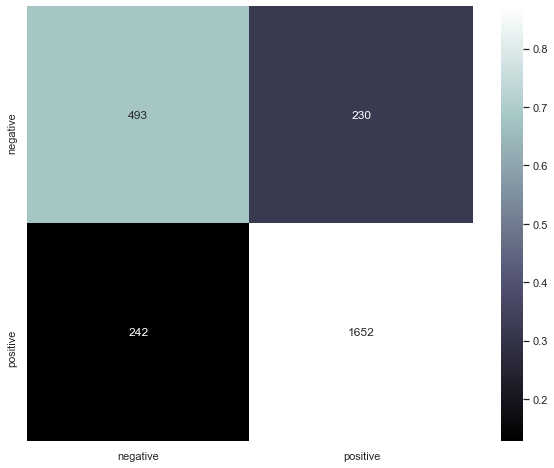




ROC AUC=0.799 



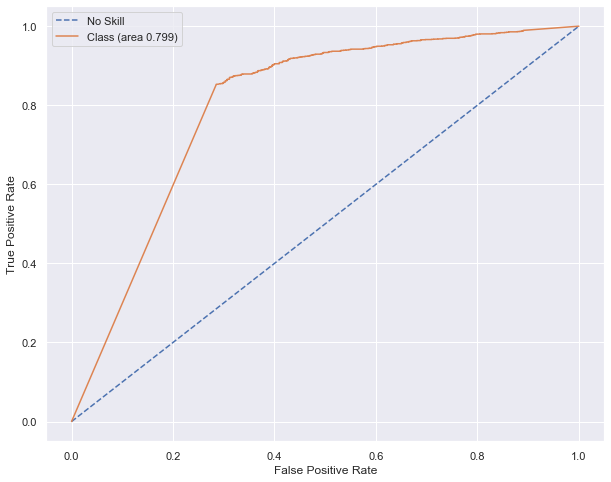



Cohen's kappa: 55.13%




In [35]:
print("\nMultinomial Naive Bayes for One-Hot encoding\n")
metrics_ML(naive_bayes.MultinomialNB(), xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


Multinomial Naive Bayes for TF-IDF

Execution time : 0.200 s
Score : 81.73 %

Classification Report

              precision    recall  f1-score   support

    negative       0.71      0.58      0.64       723
    positive       0.85      0.91      0.88      1894

    accuracy                           0.82      2617
   macro avg       0.78      0.74      0.76      2617
weighted avg       0.81      0.82      0.81      2617


Confusion Matrix





Model: f1-score=0.878 AUC=0.942




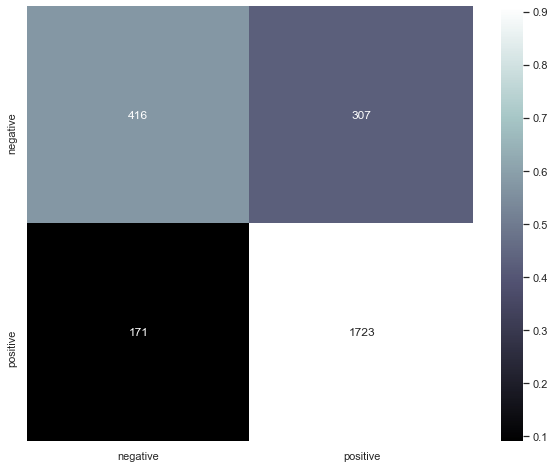

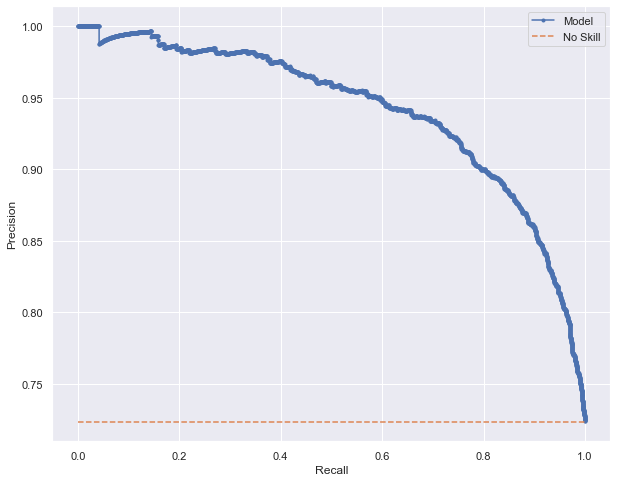




ROC AUC=0.866 



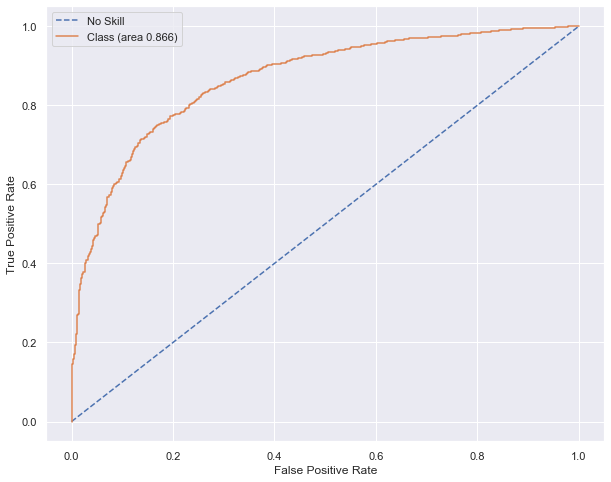



Cohen's kappa: 51.5%




In [36]:
print("\nMultinomial Naive Bayes for TF-IDF\n")
metrics_ML(naive_bayes.MultinomialNB(),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Multinomial Naive Bayes for TF-IDF n-grams

Execution time : 0.017 s
Score : 87.58 %

Classification Report

              precision    recall  f1-score   support

    negative       0.82      0.71      0.76       723
    positive       0.89      0.94      0.92      1894

    accuracy                           0.88      2617
   macro avg       0.86      0.82      0.84      2617
weighted avg       0.87      0.88      0.87      2617


Confusion Matrix





Model: f1-score=0.916 AUC=0.961







ROC AUC=0.916 



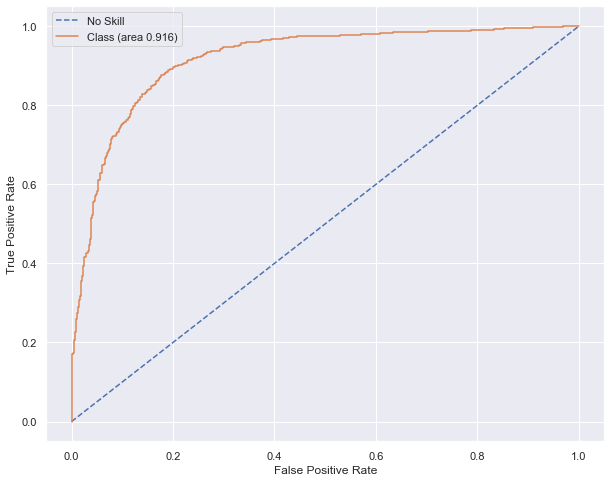



Cohen's kappa: 67.6%




In [37]:
print("\nMultinomial Naive Bayes for TF-IDF n-grams\n")
metrics_ML(naive_bayes.MultinomialNB(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


Multinomial Naive Bayes for TF-IDF char n-grams

Execution time : 0.077 s
Score : 77.3 %

Classification Report

              precision    recall  f1-score   support

    negative       0.81      0.23      0.36       723
    positive       0.77      0.98      0.86      1894

    accuracy                           0.77      2617
   macro avg       0.79      0.61      0.61      2617
weighted avg       0.78      0.77      0.72      2617


Confusion Matrix





Model: f1-score=0.862 AUC=0.931




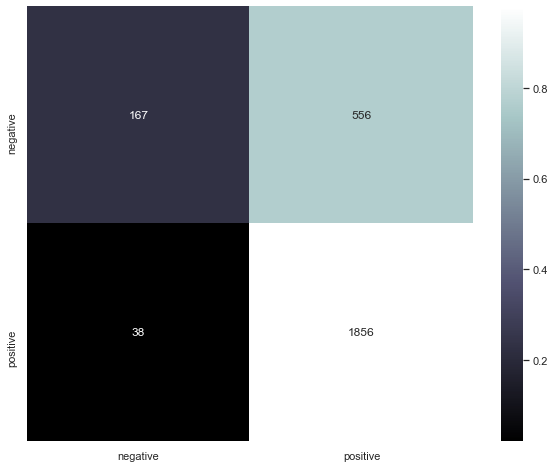




ROC AUC=0.845 



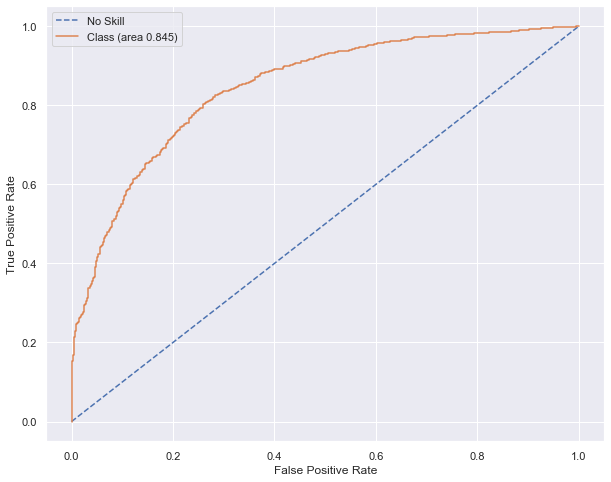



Cohen's kappa: 27.09%




In [38]:
print("\nMultinomial Naive Bayes for TF-IDF char n-grams\n")
metrics_ML(naive_bayes.MultinomialNB(),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)

In [39]:
#logistic regression

In [40]:
#optimum parameters resulting from gridsearch
#Best: 0.864502 using {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


Logistic Regression for One-Hot encoding



C:\Users\tabbe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Execution time : 36.765 s
Score : 86.4 %

Classification Report

              precision    recall  f1-score   support

    negative       0.77      0.72      0.75       723
    positive       0.90      0.92      0.91      1894

    accuracy                           0.86      2617
   macro avg       0.83      0.82      0.83      2617
weighted avg       0.86      0.86      0.86      2617


Confusion Matrix





Model: f1-score=0.907 AUC=0.925




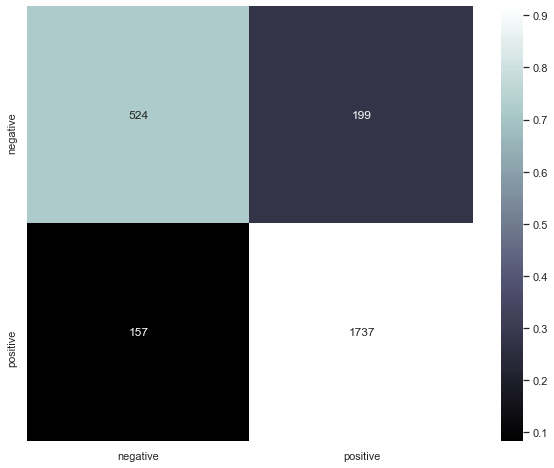

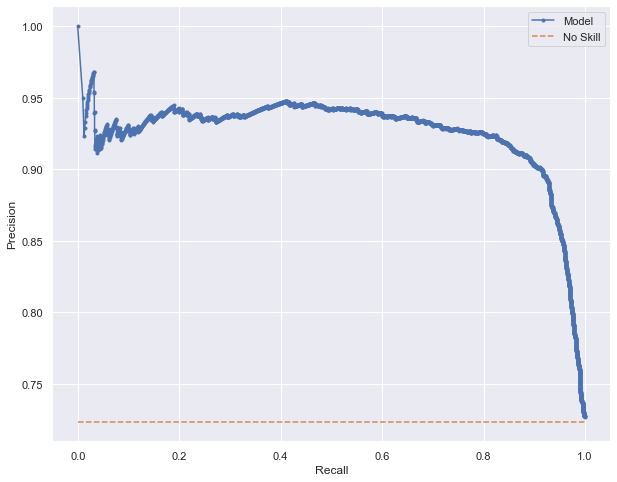




ROC AUC=0.874 





Cohen's kappa: 65.36%




In [41]:
print("\nLogistic Regression for One-Hot encoding\n")
metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)

In [42]:
print("\nLogistic Regression for TF_IDF\n")
metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Logistic Regression for TF_IDF

Execution time : 0.619 s
Score : 86.86 %

Classification Report

              precision    recall  f1-score   support

    negative       0.84      0.65      0.73       723
    positive       0.88      0.95      0.91      1894

    accuracy                           0.87      2617
   macro avg       0.86      0.80      0.82      2617
weighted avg       0.87      0.87      0.86      2617


Confusion Matrix





Model: f1-score=0.913 AUC=0.966







ROC AUC=0.922 





Cohen's kappa: 64.72%





Logistic Regression for TF_IDF n-grams

Execution time : 0.393 s
Score : 88.8 %

Classification Report

              precision    recall  f1-score   support

    negative       0.87      0.70      0.78       723
    positive       0.89      0.96      0.93      1894

    accuracy                           0.89      2617
   macro avg       0.88      0.83      0.85      2617
weighted avg       0.89      0.89      0.88      2617


Confusion Matrix





Model: f1-score=0.925 AUC=0.969




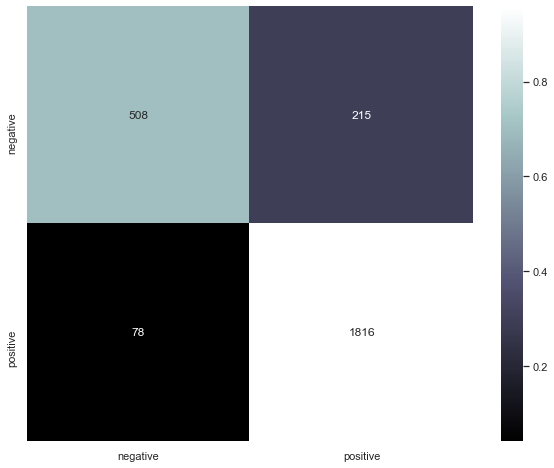




ROC AUC=0.933 



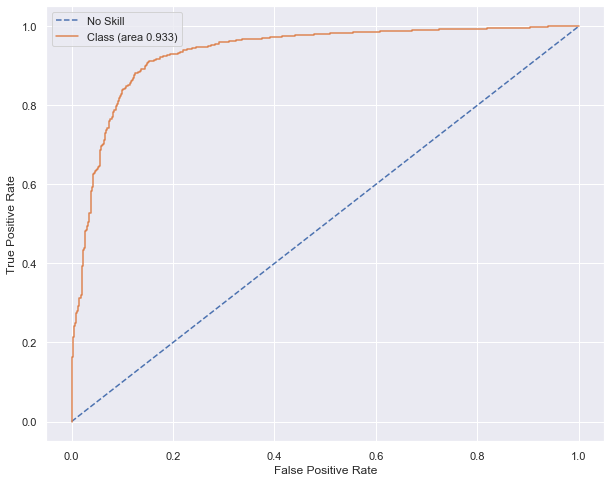



Cohen's kappa: 70.26%




In [43]:
print("\nLogistic Regression for TF_IDF n-grams\n")
metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


Logistic Regression for TF_IDF char n-grams

Execution time : 2.629 s
Score : 83.76 %

Classification Report

              precision    recall  f1-score   support

    negative       0.80      0.54      0.65       723
    positive       0.85      0.95      0.89      1894

    accuracy                           0.84      2617
   macro avg       0.82      0.75      0.77      2617
weighted avg       0.83      0.84      0.83      2617


Confusion Matrix





Model: f1-score=0.894 AUC=0.952




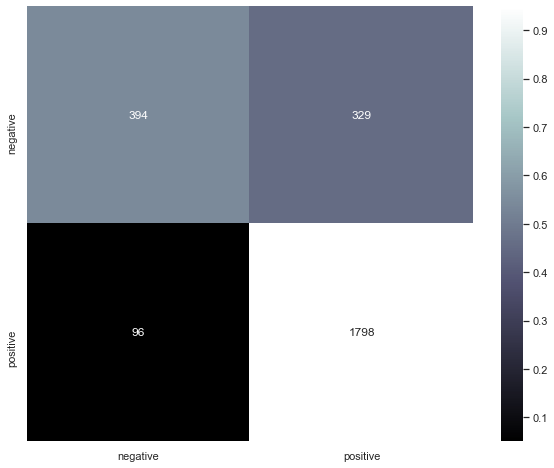

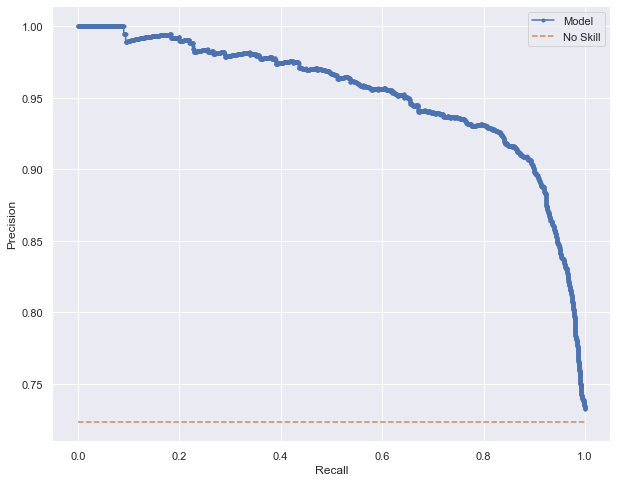




ROC AUC=0.894 





Cohen's kappa: 54.9%




In [44]:
print("\nLogistic Regression for TF_IDF char n-grams\n")
metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)

In [45]:
#SVM


SVM for One-Hot encoding

Execution time : 194.373 s
Score : 86.97 %

Classification Report

              precision    recall  f1-score   support

    negative       0.86      0.63      0.73       723
    positive       0.87      0.96      0.91      1894

    accuracy                           0.87      2617
   macro avg       0.87      0.80      0.82      2617
weighted avg       0.87      0.87      0.86      2617


Confusion Matrix





Model: f1-score=0.914 AUC=0.931




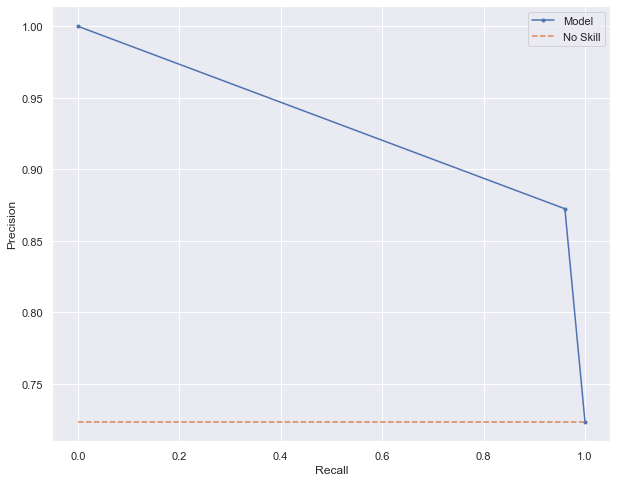




ROC AUC=0.796 



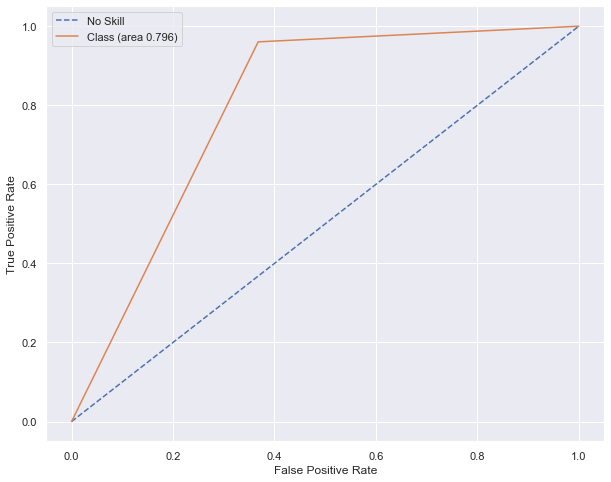



Cohen's kappa: 64.52%




In [46]:
print("\nSVM for One-Hot encoding\n")
metrics_ML(svm.SVC(),  xtrain_count, train_y, xvalid_count, valid_y, gb=False)


SVM for TF_IDF

Execution time : 185.911 s
Score : 87.08 %

Classification Report

              precision    recall  f1-score   support

    negative       0.84      0.66      0.74       723
    positive       0.88      0.95      0.91      1894

    accuracy                           0.87      2617
   macro avg       0.86      0.81      0.83      2617
weighted avg       0.87      0.87      0.87      2617


Confusion Matrix





Model: f1-score=0.914 AUC=0.933




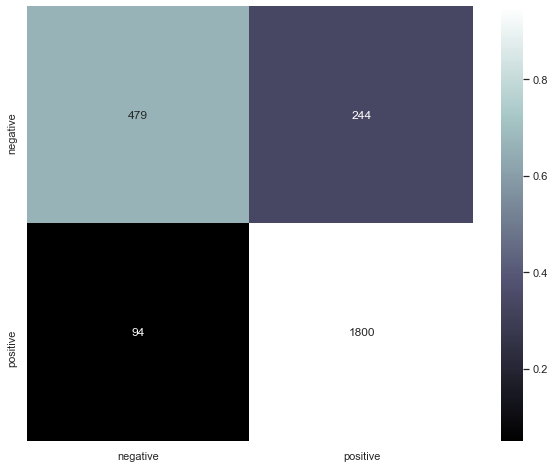




ROC AUC=0.806 





Cohen's kappa: 65.49%




In [47]:
print("\nSVM for TF_IDF\n")
metrics_ML(svm.SVC(),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=False)


SVM for TF_IDF n-grams

Execution time : 152.338 s
Score : 89.03 %

Classification Report

              precision    recall  f1-score   support

    negative       0.86      0.72      0.78       723
    positive       0.90      0.96      0.93      1894

    accuracy                           0.89      2617
   macro avg       0.88      0.84      0.85      2617
weighted avg       0.89      0.89      0.89      2617


Confusion Matrix





Model: f1-score=0.927 AUC=0.943




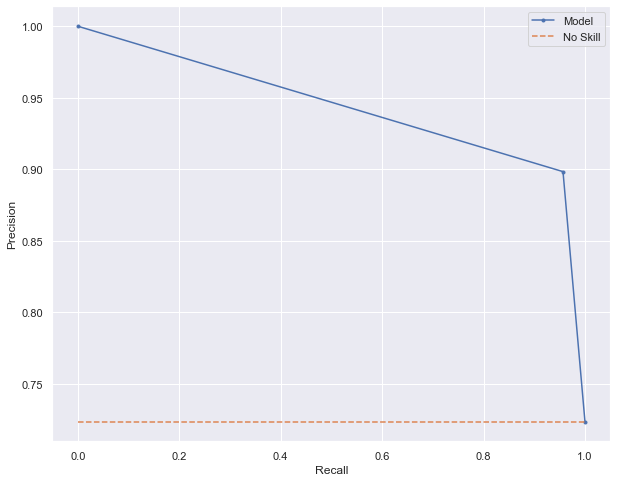




ROC AUC=0.837 



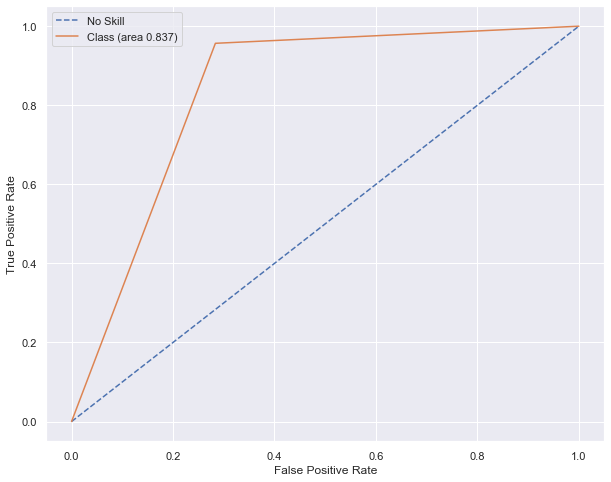



Cohen's kappa: 71.05%




In [48]:
print("\nSVM for TF_IDF n-grams\n")
metrics_ML(svm.SVC(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=False)


SVM for TF_IDF char n-grams

Execution time : 614.141 s
Score : 86.32 %

Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.63      0.72       723
    positive       0.87      0.95      0.91      1894

    accuracy                           0.86      2617
   macro avg       0.85      0.79      0.81      2617
weighted avg       0.86      0.86      0.86      2617


Confusion Matrix





Model: f1-score=0.910 AUC=0.929




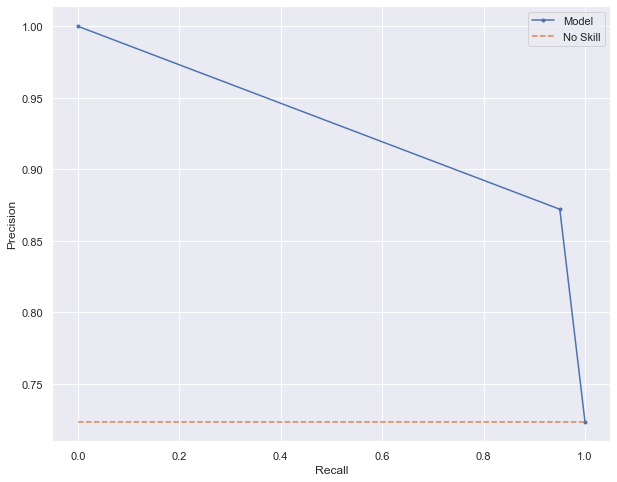




ROC AUC=0.793 





Cohen's kappa: 63.11%




In [49]:
print("\nSVM for TF_IDF char n-grams\n")
metrics_ML(svm.SVC(),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=False)

In [50]:
#k-nn


k-NN for One-Hot encoding

Execution time : 0.025 s
Score : 83.95 %

Classification Report

              precision    recall  f1-score   support

    negative       0.80      0.56      0.66       723
    positive       0.85      0.95      0.90      1894

    accuracy                           0.84      2617
   macro avg       0.82      0.75      0.78      2617
weighted avg       0.84      0.84      0.83      2617


Confusion Matrix





Model: f1-score=0.895 AUC=0.954




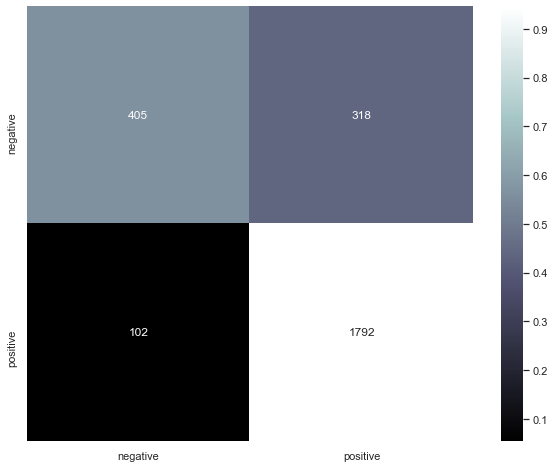




ROC AUC=0.896 



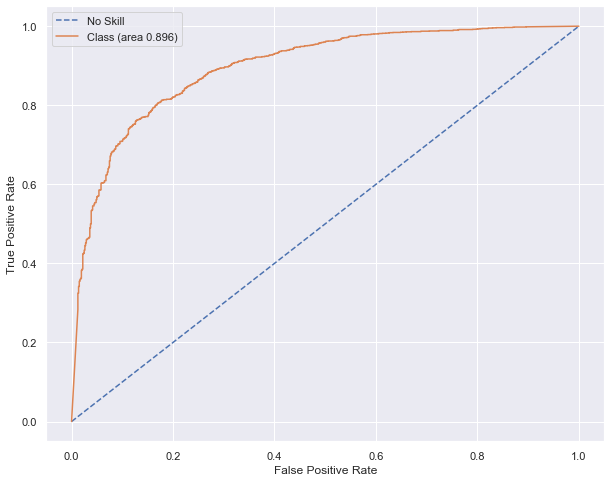



Cohen's kappa: 55.78%




In [51]:
print("\nk-NN for One-Hot encoding\n")
metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


k-NN for TF_IDF

Execution time : 0.030 s
Score : 82.12 %

Classification Report

              precision    recall  f1-score   support

    negative       0.77      0.51      0.61       723
    positive       0.83      0.94      0.88      1894

    accuracy                           0.82      2617
   macro avg       0.80      0.72      0.75      2617
weighted avg       0.81      0.82      0.81      2617


Confusion Matrix





Model: f1-score=0.884 AUC=0.942







ROC AUC=0.869 



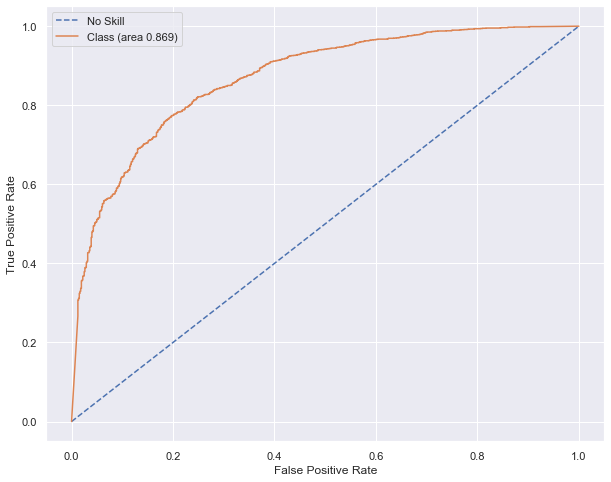



Cohen's kappa: 50.07%




In [52]:
print("\nk-NN for TF_IDF\n")
metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


k-NN for TF_IDF n-grams

Execution time : 0.025 s
Score : 84.45 %

Classification Report

              precision    recall  f1-score   support

    negative       0.78      0.61      0.68       723
    positive       0.86      0.94      0.90      1894

    accuracy                           0.84      2617
   macro avg       0.82      0.77      0.79      2617
weighted avg       0.84      0.84      0.84      2617


Confusion Matrix





Model: f1-score=0.897 AUC=0.953




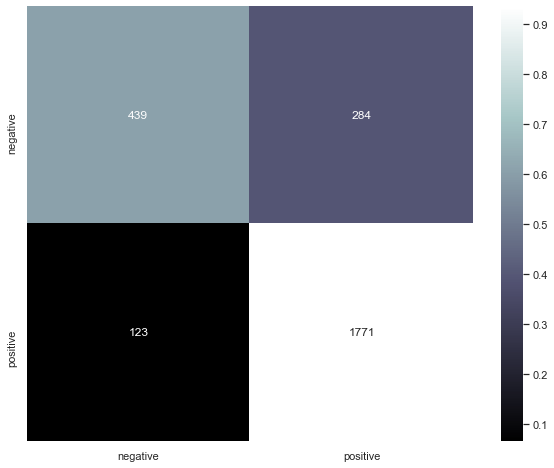

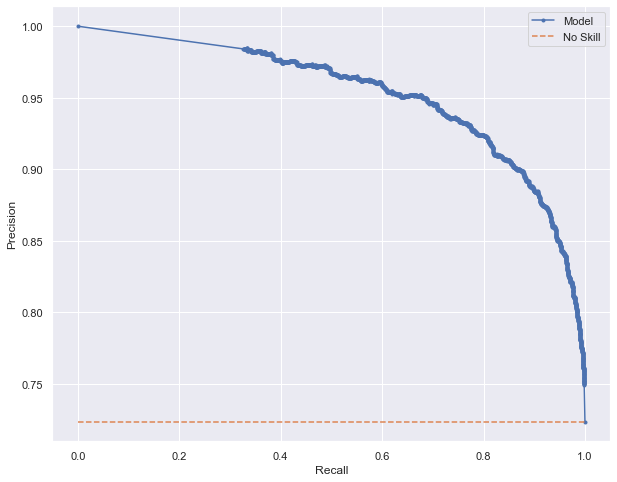




ROC AUC=0.893 





Cohen's kappa: 58.23%




In [53]:
print("\nk-NN for TF_IDF n-grams\n")
metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


k-NN for TF_IDF char n-grams

Execution time : 0.118 s
Score : 82.77 %

Classification Report

              precision    recall  f1-score   support

    negative       0.72      0.61      0.66       723
    positive       0.86      0.91      0.88      1894

    accuracy                           0.83      2617
   macro avg       0.79      0.76      0.77      2617
weighted avg       0.82      0.83      0.82      2617


Confusion Matrix





Model: f1-score=0.884 AUC=0.945




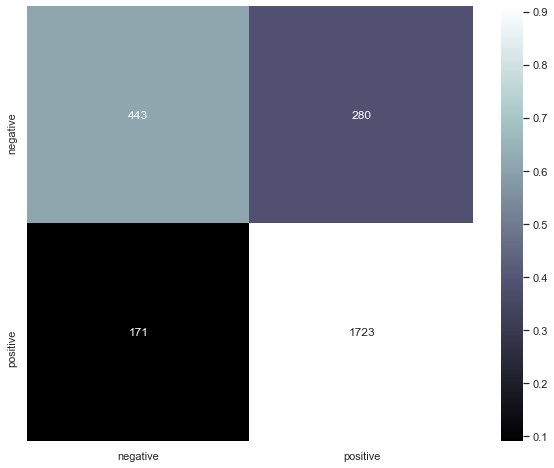




ROC AUC=0.877 



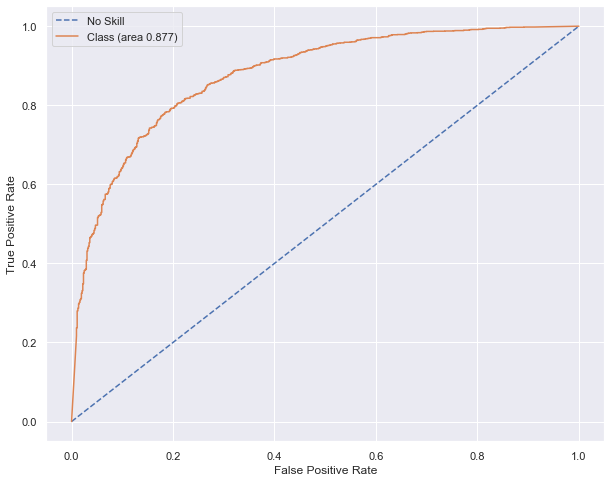



Cohen's kappa: 54.8%




In [54]:
print("\nk-NN for TF_IDF char n-grams\n")
metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)

In [55]:
#random forests
#optimal parameters are the same as default parameters


Random Forest for One-Hot encoding

Execution time : 27.924 s
Score : 87.58 %

Classification Report

              precision    recall  f1-score   support

    negative       0.89      0.63      0.74       723
    positive       0.87      0.97      0.92      1894

    accuracy                           0.88      2617
   macro avg       0.88      0.80      0.83      2617
weighted avg       0.88      0.88      0.87      2617


Confusion Matrix





Model: f1-score=0.919 AUC=0.968




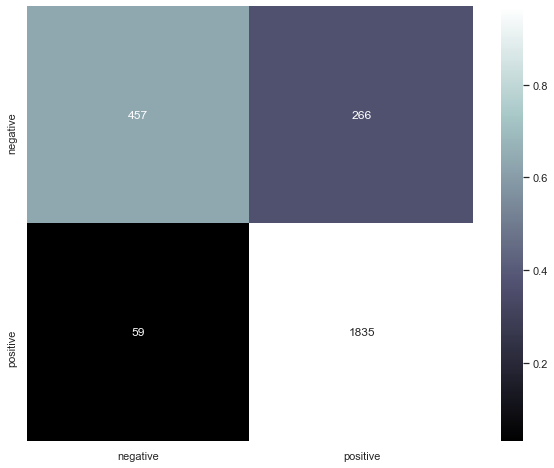

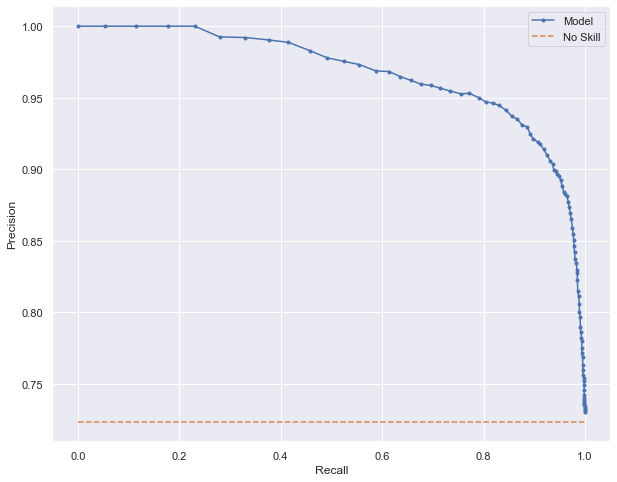




ROC AUC=0.926 



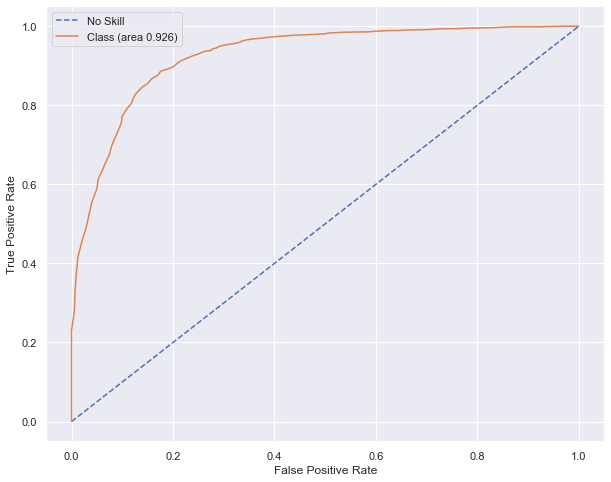



Cohen's kappa: 65.93%




In [56]:
print("\nRandom Forest for One-Hot encoding\n")
metrics_ML(ensemble.RandomForestClassifier(),  xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


Random Forest for TF_IDF

Execution time : 23.270 s
Score : 88.96 %

Classification Report

              precision    recall  f1-score   support

    negative       0.89      0.69      0.77       723
    positive       0.89      0.97      0.93      1894

    accuracy                           0.89      2617
   macro avg       0.89      0.83      0.85      2617
weighted avg       0.89      0.89      0.88      2617


Confusion Matrix





Model: f1-score=0.927 AUC=0.971




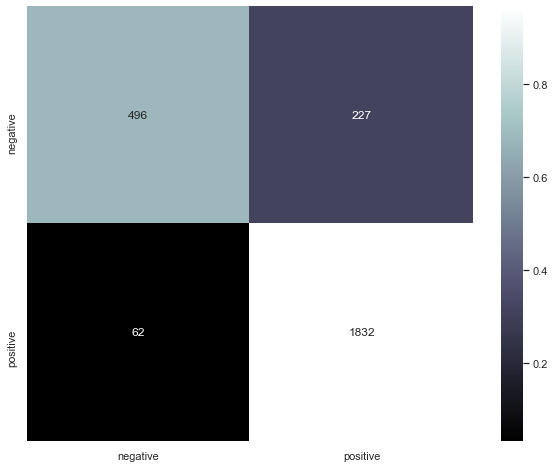

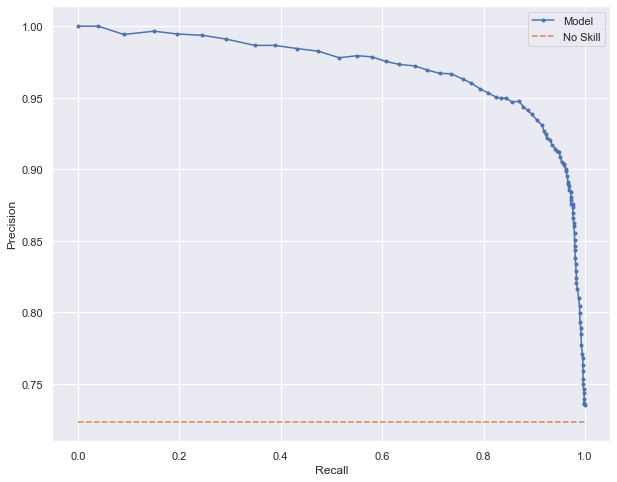




ROC AUC=0.935 



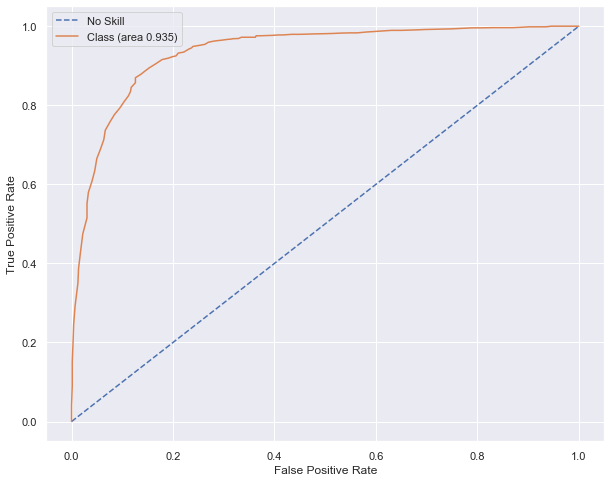



Cohen's kappa: 70.29%




In [57]:
print("\nRandom Forest for TF_IDF\n")
metrics_ML(ensemble.RandomForestClassifier(),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Random Forest for TF_IDF n-grams

Execution time : 20.810 s
Score : 90.79 %

Classification Report

              precision    recall  f1-score   support

    negative       0.90      0.75      0.82       723
    positive       0.91      0.97      0.94      1894

    accuracy                           0.91      2617
   macro avg       0.90      0.86      0.88      2617
weighted avg       0.91      0.91      0.91      2617


Confusion Matrix





Model: f1-score=0.938 AUC=0.977




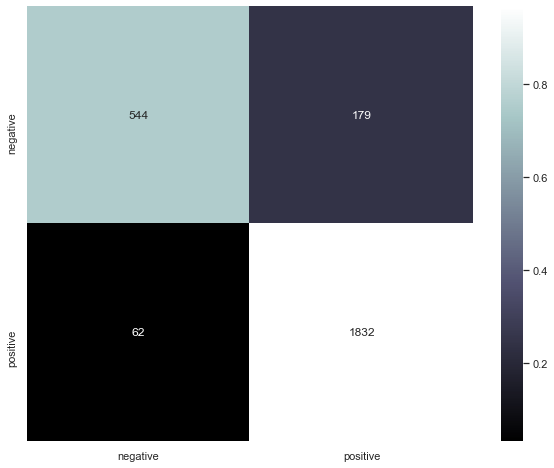

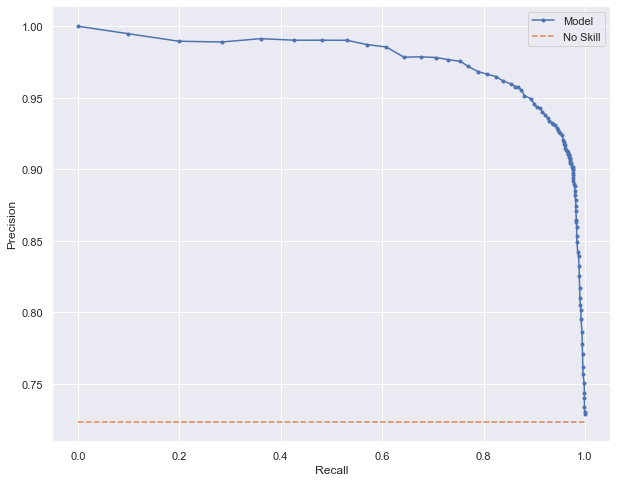




ROC AUC=0.949 



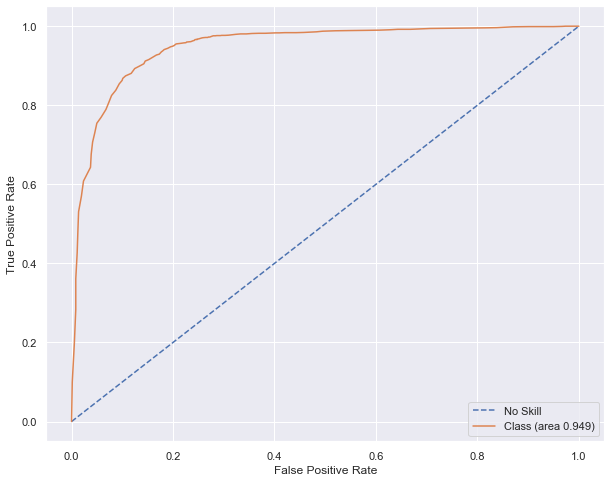



Cohen's kappa: 75.76%




In [58]:
print("\nRandom Forest for TF_IDF n-grams\n")
metrics_ML(ensemble.RandomForestClassifier(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


Random Forest for TF_IDF char n-grams

Execution time : 75.681 s
Score : 87.73 %

Classification Report

              precision    recall  f1-score   support

    negative       0.88      0.65      0.74       723
    positive       0.88      0.97      0.92      1894

    accuracy                           0.88      2617
   macro avg       0.88      0.81      0.83      2617
weighted avg       0.88      0.88      0.87      2617


Confusion Matrix





Model: f1-score=0.919 AUC=0.966




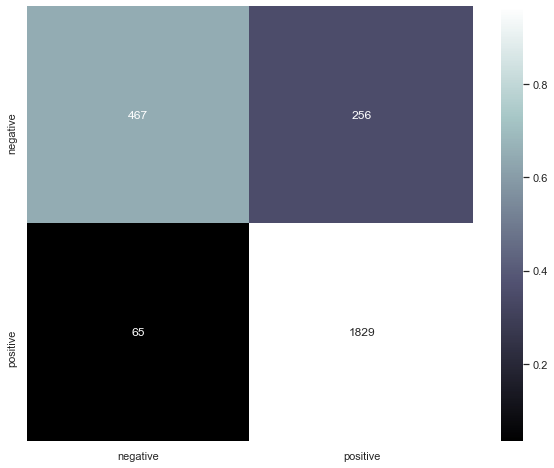

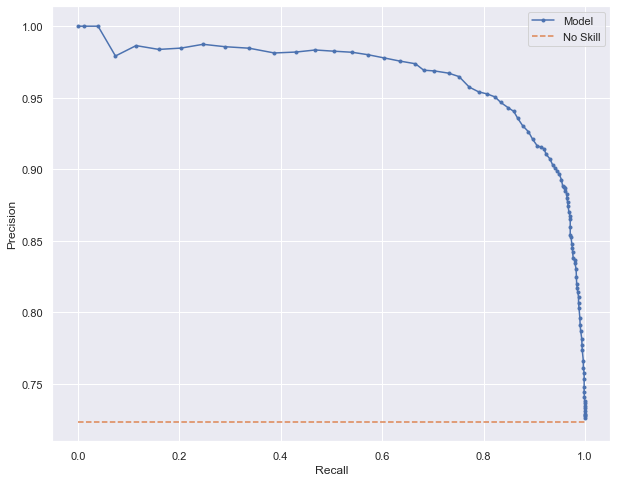




ROC AUC=0.928 



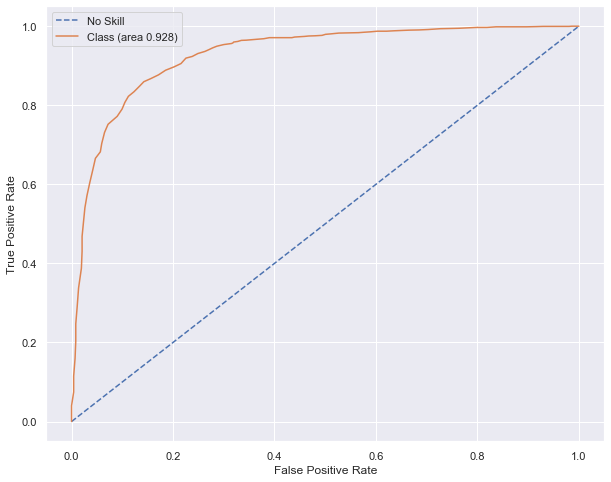



Cohen's kappa: 66.6%




In [59]:
print("\nRandom Forest for TF_IDF char n-grams\n")
metrics_ML(ensemble.RandomForestClassifier(),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)

In [60]:
#stochastic gradient descent
#optimal parameters are the same as default parameters


Stochastic Gradient Descent with early stopping for One-Hot encoding

Early Stopping : 10 iterations without change
Execution time : 0.512 s
Score : 83.95 %

Classification Report

              precision    recall  f1-score   support

    negative       0.67      0.82      0.74       723
    positive       0.93      0.85      0.88      1894

    accuracy                           0.84      2617
   macro avg       0.80      0.83      0.81      2617
weighted avg       0.86      0.84      0.84      2617


Confusion Matrix





Model: f1-score=0.884 AUC=0.941




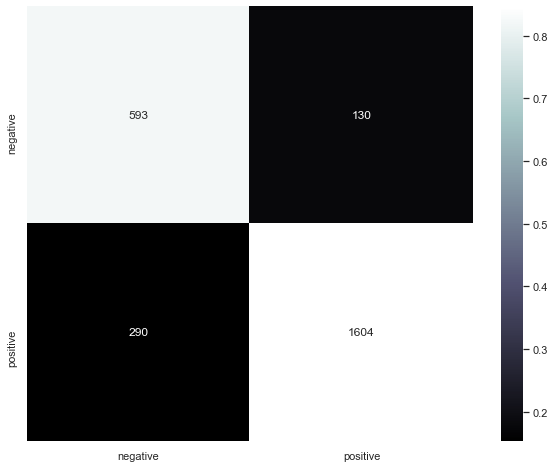

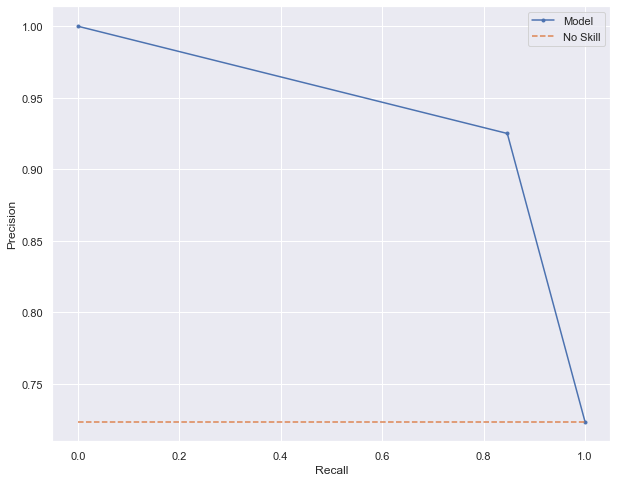




ROC AUC=0.834 



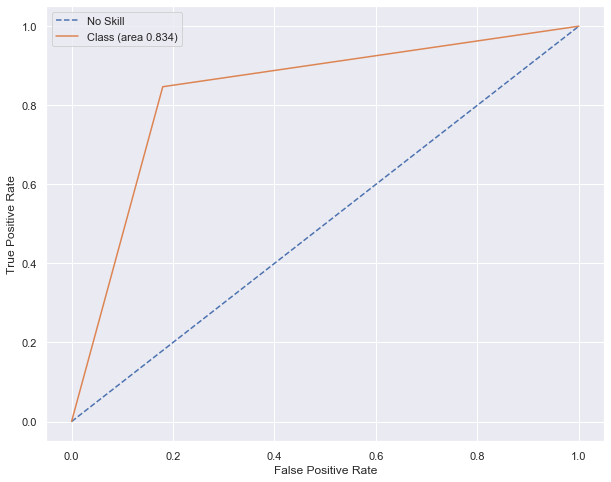



Cohen's kappa: 62.44%




In [61]:
print("\nStochastic Gradient Descent with early stopping for One-Hot encoding\n")
print("Early Stopping : 10 iterations without change")
metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ),  xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


Stochastic Gradient Descent with early stopping for TF-IDF

Early Stopping : 10 iterations without change
Execution time : 0.344 s
Score : 87.12 %

Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.67      0.74       723
    positive       0.88      0.95      0.91      1894

    accuracy                           0.87      2617
   macro avg       0.86      0.81      0.83      2617
weighted avg       0.87      0.87      0.87      2617


Confusion Matrix





Model: f1-score=0.914 AUC=0.963




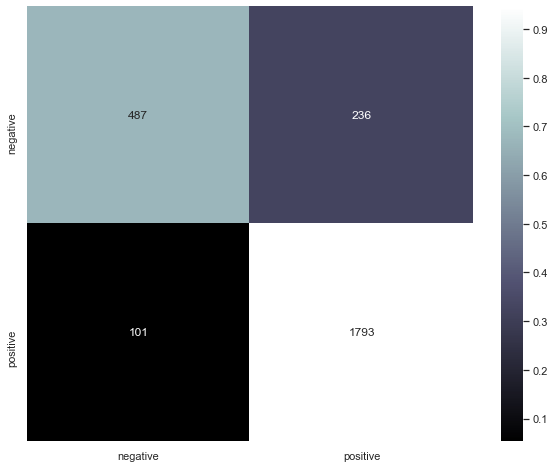

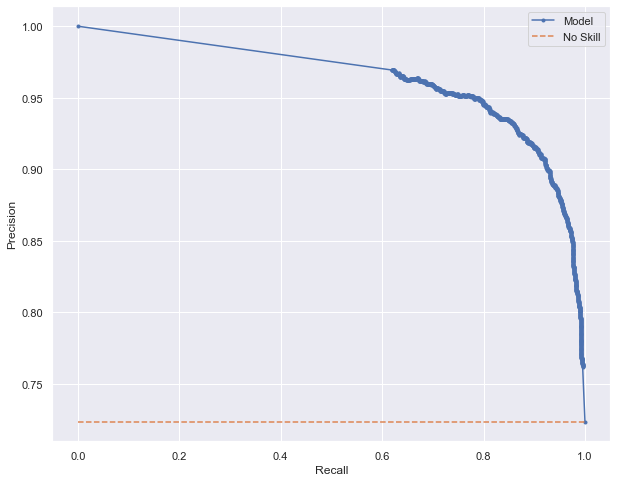




ROC AUC=0.913 



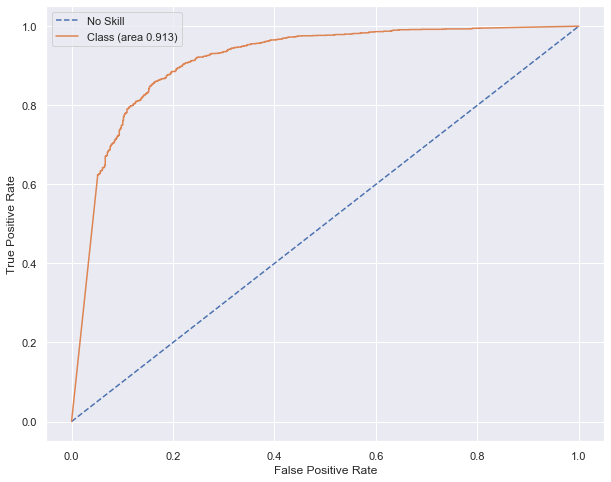



Cohen's kappa: 65.83%




In [62]:
print("\nStochastic Gradient Descent with early stopping for TF-IDF\n")
print("Early Stopping : 10 iterations without change")
metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ),xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Stochastic Gradient Descent with early stopping for TF-IDF N-gram

Early Stopping : 10 iterations without change
Execution time : 0.235 s
Score : 87.81 %

Classification Report

              precision    recall  f1-score   support

    negative       0.81      0.73      0.77       723
    positive       0.90      0.94      0.92      1894

    accuracy                           0.88      2617
   macro avg       0.86      0.83      0.84      2617
weighted avg       0.88      0.88      0.88      2617


Confusion Matrix





Model: f1-score=0.917 AUC=0.960




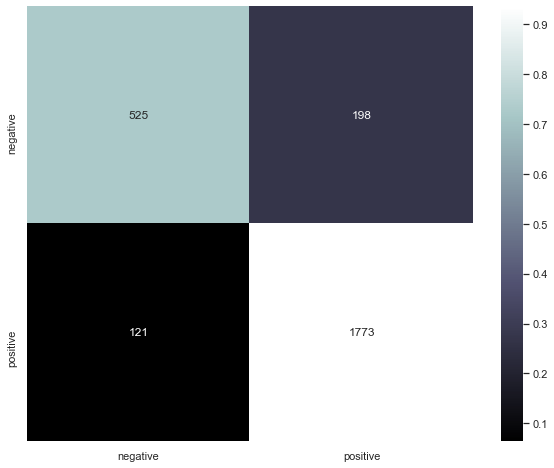

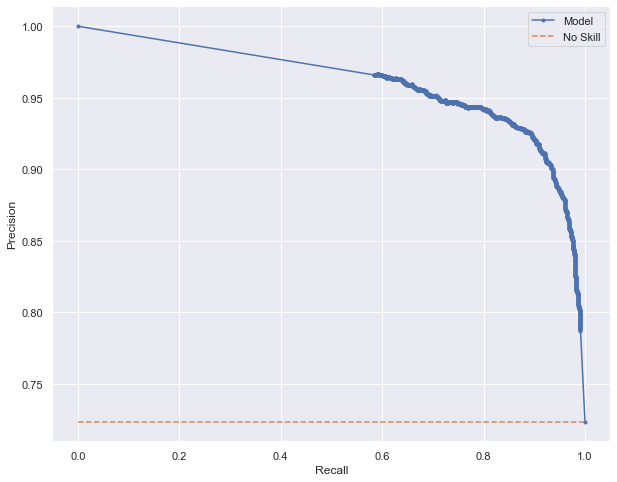




ROC AUC=0.910 



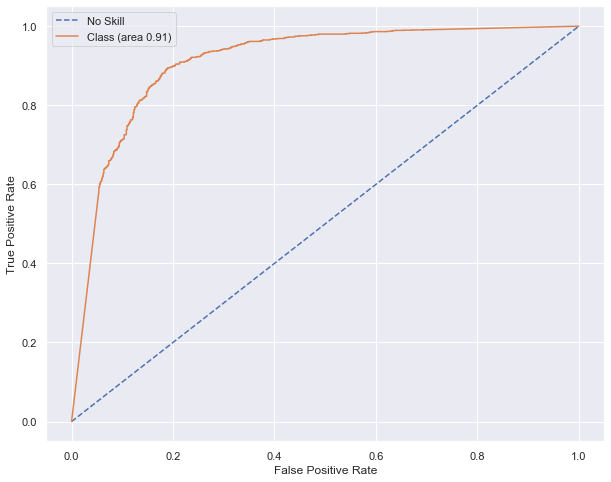



Cohen's kappa: 68.48%




In [63]:
print("\nStochastic Gradient Descent with early stopping for TF-IDF N-gram\n")
print("Early Stopping : 10 iterations without change")
metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ),xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


Stochastic Gradient Descent with early stopping for TF-IDF char n-gram

Early Stopping : 10 iterations without change
Execution time : 1.106 s
Score : 86.47 %

Classification Report

              precision    recall  f1-score   support

    negative       0.81      0.66      0.73       723
    positive       0.88      0.94      0.91      1894

    accuracy                           0.86      2617
   macro avg       0.85      0.80      0.82      2617
weighted avg       0.86      0.86      0.86      2617


Confusion Matrix





Model: f1-score=0.910 AUC=0.962




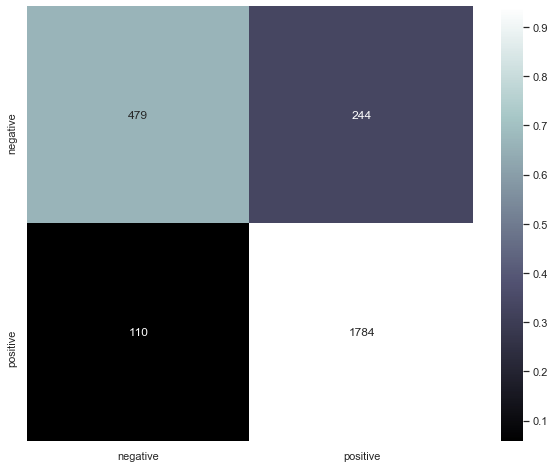

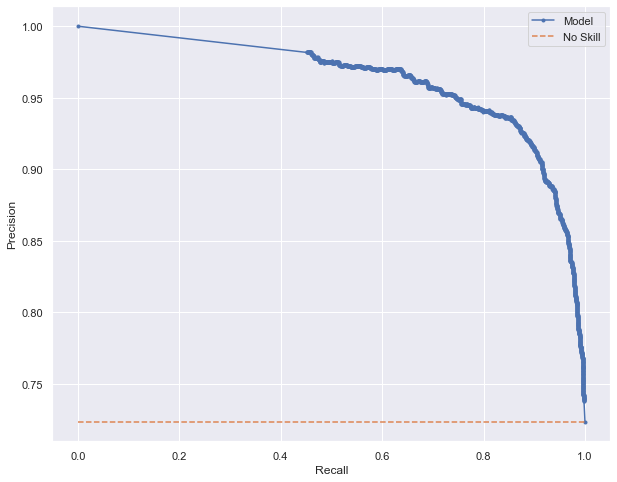




ROC AUC=0.913 



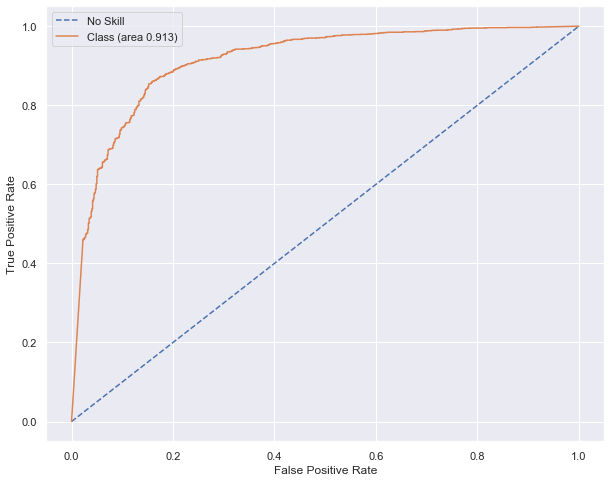



Cohen's kappa: 64.12%




In [64]:
print("\nStochastic Gradient Descent with early stopping for TF-IDF char n-gram\n")
print("Early Stopping : 10 iterations without change")
metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)

In [65]:
#gradient boosting
#optimal parameters are the same as default parameters


Gradient Boosting with early stopping for Count Vectors

Early Stopping : 5 iterations without change
Execution time : 59.988 s
Score : 90.29 %

Classification Report

              precision    recall  f1-score   support

    negative       0.88      0.75      0.81       723
    positive       0.91      0.96      0.93      1894

    accuracy                           0.90      2617
   macro avg       0.90      0.85      0.87      2617
weighted avg       0.90      0.90      0.90      2617


Confusion Matrix





Model: f1-score=0.935 AUC=0.971




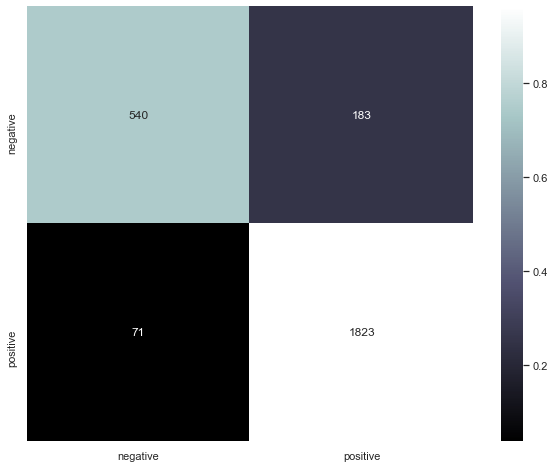

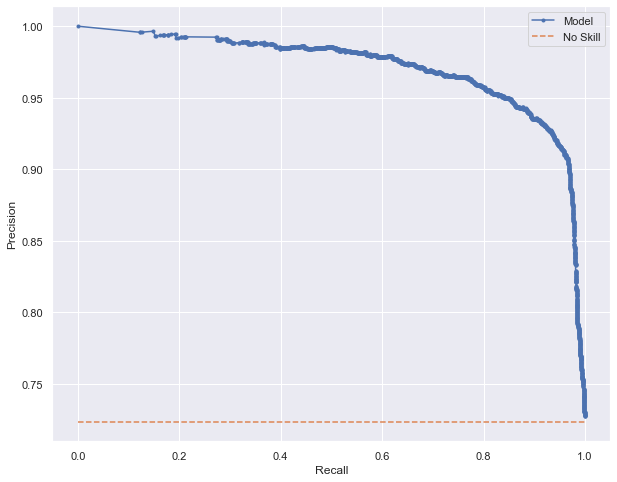




ROC AUC=0.936 



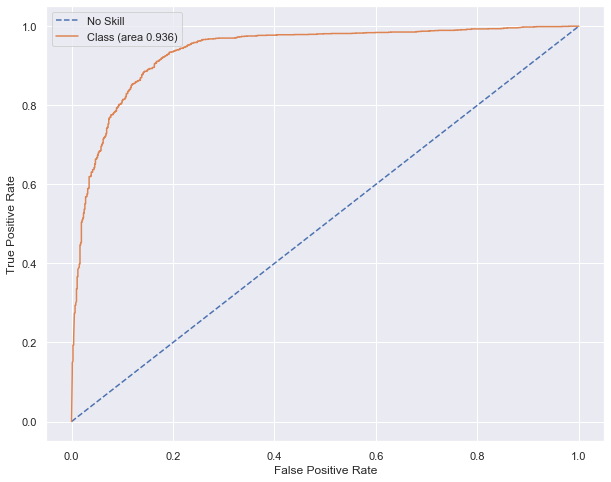



Cohen's kappa: 74.51%




In [66]:
print("\nGradient Boosting with early stopping for Count Vectors\n")
print("Early Stopping : 5 iterations without change")
metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0), xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


Gradient Boosting with early stopping for TF-IDF

Early Stopping : 5 iterations without change
Execution time : 34.968 s
Score : 89.91 %

Classification Report

              precision    recall  f1-score   support

    negative       0.88      0.74      0.80       723
    positive       0.91      0.96      0.93      1894

    accuracy                           0.90      2617
   macro avg       0.89      0.85      0.87      2617
weighted avg       0.90      0.90      0.90      2617


Confusion Matrix





Model: f1-score=0.932 AUC=0.973




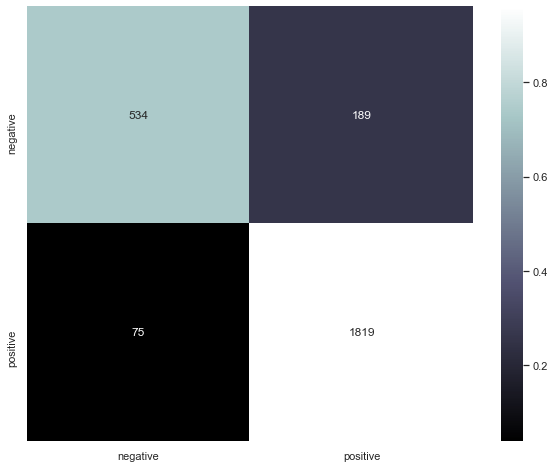

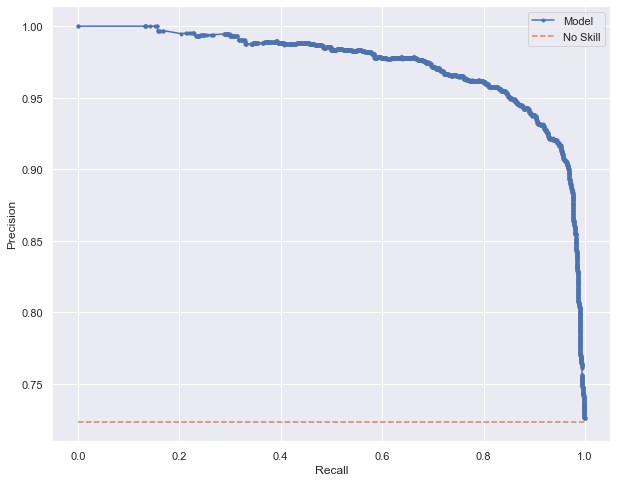




ROC AUC=0.939 



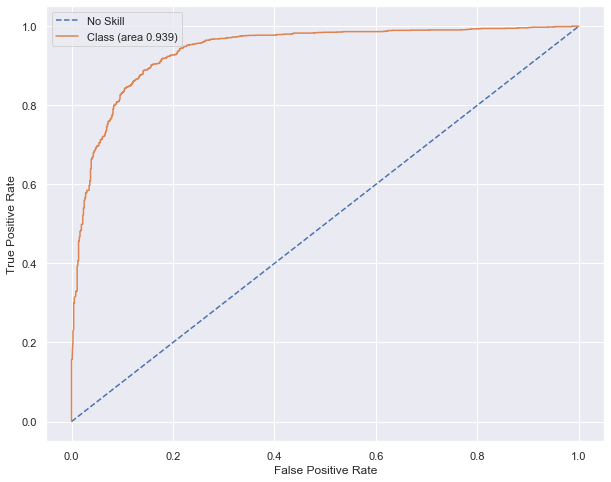



Cohen's kappa: 73.48%




In [67]:
print("\nGradient Boosting with early stopping for TF-IDF\n")
print("Early Stopping : 5 iterations without change")
metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0), xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Gradient Boosting with early stopping for TF_IDF ngram

Early Stopping : 5 iterations without change
Execution time : 32.877 s
Score : 90.33 %

Classification Report

              precision    recall  f1-score   support

    negative       0.89      0.74      0.81       723
    positive       0.91      0.97      0.94      1894

    accuracy                           0.90      2617
   macro avg       0.90      0.85      0.87      2617
weighted avg       0.90      0.90      0.90      2617


Confusion Matrix





Model: f1-score=0.935 AUC=0.976




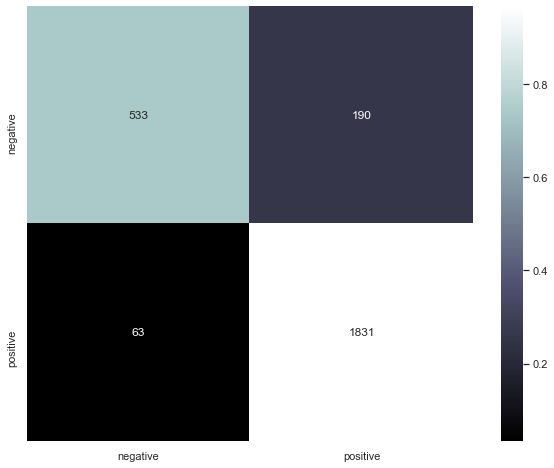

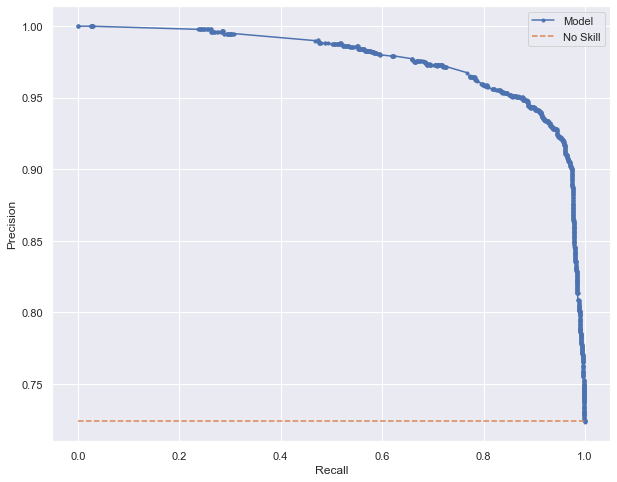




ROC AUC=0.943 



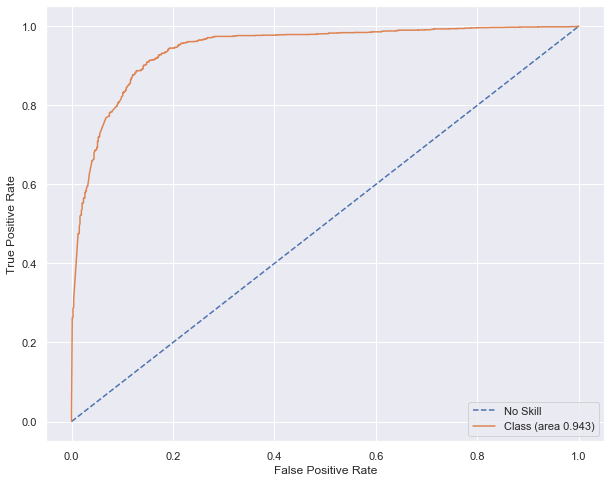



Cohen's kappa: 74.44%




In [68]:
print("\nGradient Boosting with early stopping for TF_IDF ngram\n")
print("Early Stopping : 5 iterations without change")
metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0),xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)
    


Gradient Boosting with early stopping for TF-IDF ngram chars

Early Stopping : 5 iterations without change
Execution time : 185.207 s
Score : 88.23 %

Classification Report

              precision    recall  f1-score   support

    negative       0.87      0.68      0.76       723
    positive       0.89      0.96      0.92      1894

    accuracy                           0.88      2617
   macro avg       0.88      0.82      0.84      2617
weighted avg       0.88      0.88      0.88      2617


Confusion Matrix





Model: f1-score=0.922 AUC=0.967




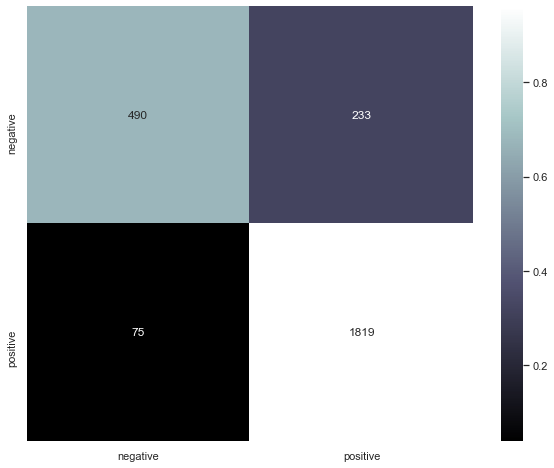

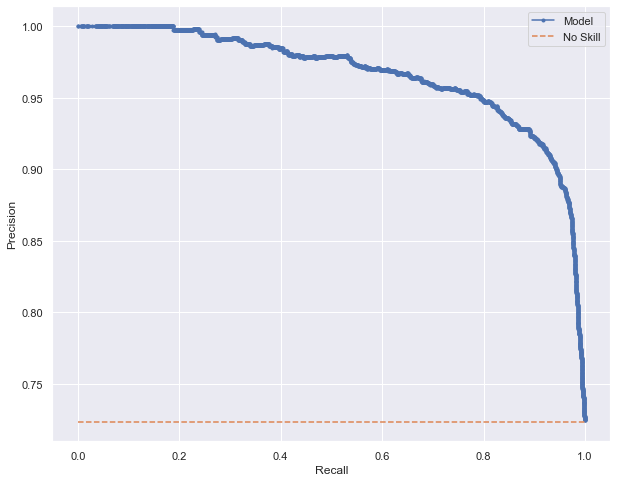




ROC AUC=0.924 



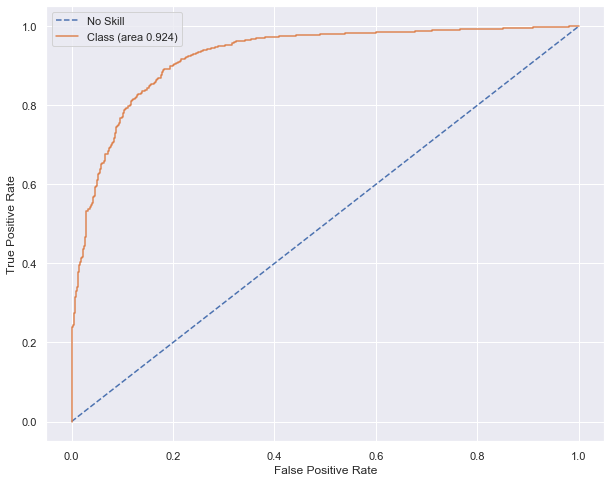



Cohen's kappa: 68.44%




In [69]:
print("\nGradient Boosting with early stopping for TF-IDF ngram chars\n")
print("Early Stopping : 5 iterations without change")
metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0),xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)


Gradient Boosting with early stopping for Word Embeddings

Early Stopping : 5 iterations without change
Execution time : 8.586 s
Score : 72.91 %

Classification Report

              precision    recall  f1-score   support

    negative       1.00      0.02      0.04       723
    positive       0.73      1.00      0.84      1894

    accuracy                           0.73      2617
   macro avg       0.86      0.51      0.44      2617
weighted avg       0.80      0.73      0.62      2617


Confusion Matrix





Model: f1-score=0.842 AUC=0.830




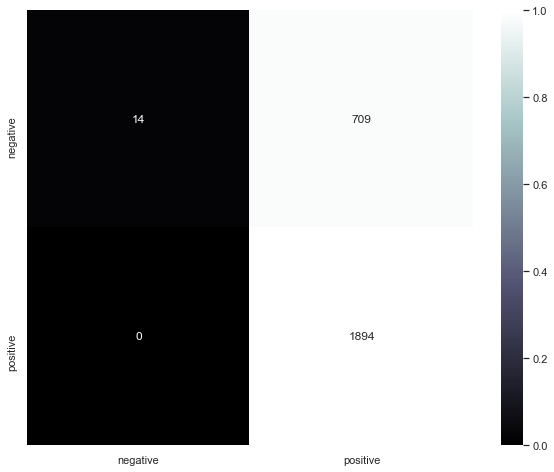

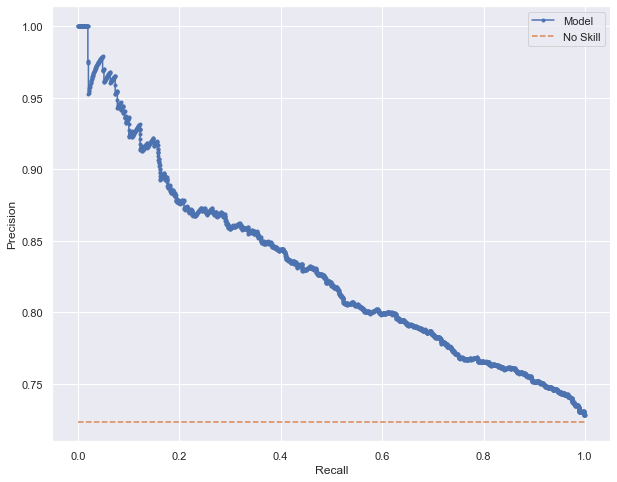




ROC AUC=0.652 



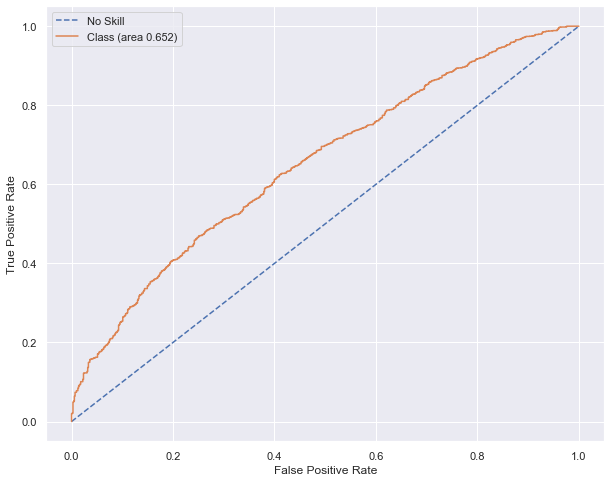



Cohen's kappa: 2.78%




In [70]:
print("\nGradient Boosting with early stopping for Word Embeddings\n")
print("Early Stopping : 5 iterations without change")
metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0),train_seq_x, train_y, valid_seq_x, valid_y, gb=True)

In [71]:
#XGBoost
#All the XGBoost have early stopping implemented with 10 rounds

In [72]:
def xgb_model(X_train, y_train, X_test, y_test, labels=labels):
    model = XGBClassifier(n_estimators=1000, subsample=0.8)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    if len(labels)>2:
        model.fit(X_train, y_train, eval_metric=["merror", "mlogloss"],  eval_set=eval_set,early_stopping_rounds=10, verbose=False) #
    else:
        model.fit(X_train, y_train, eval_metric=["error", "logloss"],  eval_set=eval_set,early_stopping_rounds=10, verbose=False) #
    
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(valid_y, predictions)
    print("\nAccuracy: %.2f%%" % (accuracy * 100.0))
    return model, y_pred, accuracy

def rmsle_eval(y, y0):
    
    y0=y0.get_label()    
    assert len(y) == len(y0)
    return 'error',np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))



In [73]:
#XGBoost for count vectors


XGBoost for Count Vectors



C:\Users\tabbe\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Accuracy: 90.26%

Classification Report

              precision    recall  f1-score   support

    negative       0.87      0.76      0.81       723
    positive       0.91      0.96      0.93      1894

    accuracy                           0.90      2617
   macro avg       0.89      0.86      0.87      2617
weighted avg       0.90      0.90      0.90      2617


Confusion Matrix



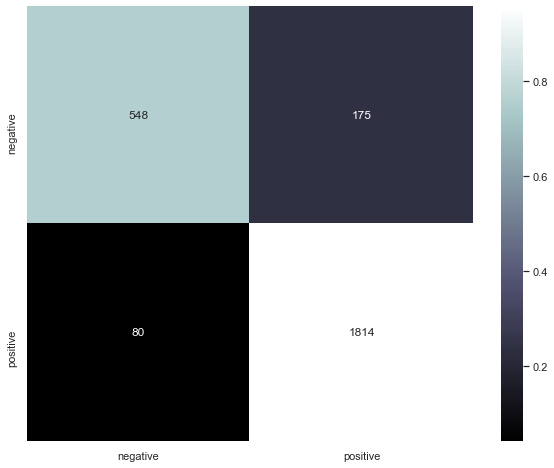

In [74]:
print("\nXGBoost for Count Vectors\n")
xgbs, pred, accuracy = xgb_model(xtrain_count, train_y_sw, xvalid_count, valid_y_sw, labels=labels)
print("\nClassification Report\n")
print(classification_report(valid_y_sw, pred, target_names=labels))
cm = confusion_matrix(valid_y_sw, pred)
print("\nConfusion Matrix\n")
Metric.plot_confusion_matrix(cm, labels)


The precision of the model is 91.2%


Model: f1-score=0.934 AUC=0.975




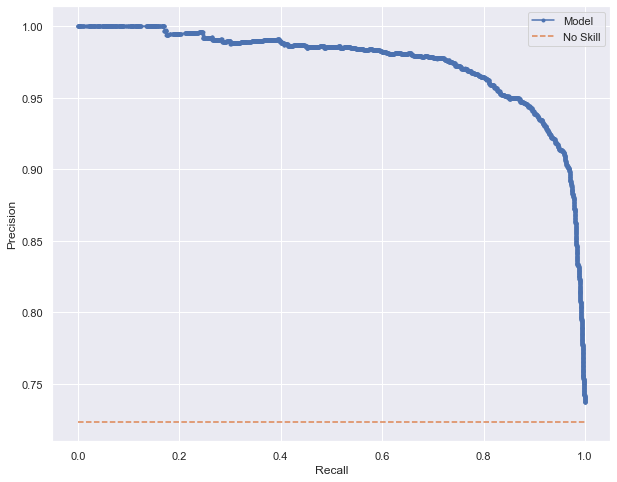




ROC AUC=0.944 



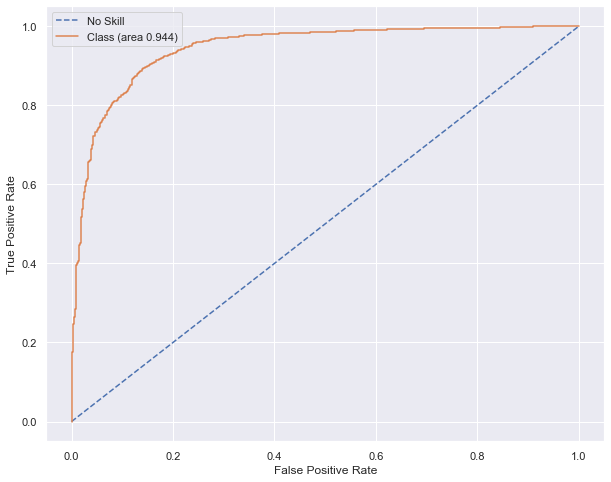


Evaluation Curves


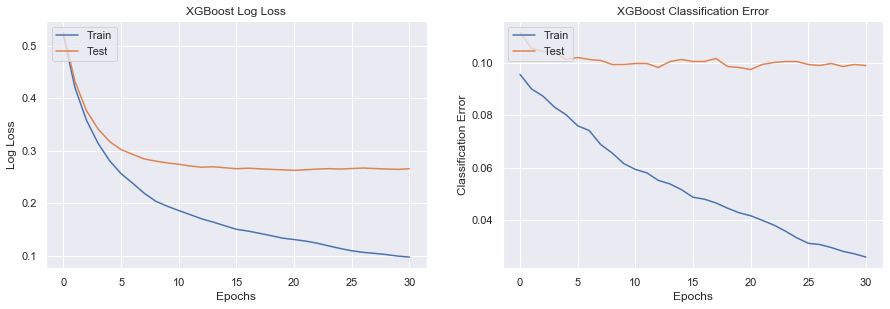



Cohen's kappa: 74.6%




In [75]:
print(f"\nThe precision of the model is {round(100*precision_score(valid_y_sw, pred, labels),2)}%")
Metric.precision_recall_curve(xgbs,  xvalid_count,  valid_y_sw, labels, gb=True)
print("\n")
Metric.roc_auc_curve(xgbs, xvalid_count, valid_y_sw,  labels, gb=True)
print("\nEvaluation Curves")
Metric.plot_eval_xgb(xgbs,  labels)
print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_count)),2)}%\n\n")

In [76]:
#XGBoost TF-IDF


XGBoost for TF_IDF



C:\Users\tabbe\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Accuracy: 90.52%

Classification Report

              precision    recall  f1-score   support

    negative       0.87      0.77      0.82       723
    positive       0.92      0.96      0.94      1894

    accuracy                           0.91      2617
   macro avg       0.89      0.86      0.88      2617
weighted avg       0.90      0.91      0.90      2617


Confusion Matrix



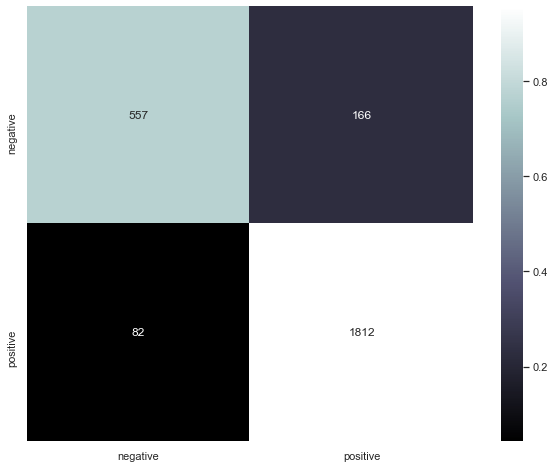

In [77]:
print("\nXGBoost for TF_IDF\n")
xgbs, pred, accuracy = xgb_model(xtrain_tfidf, train_y, xvalid_tfidf, valid_y, labels=labels)
print("\nClassification Report\n")
print(classification_report(valid_y, pred, target_names=labels))
cm = confusion_matrix(valid_y, pred)
print("\nConfusion Matrix\n")
Metric.plot_confusion_matrix(cm, labels)


The precision of the model is 91.61%


Model: f1-score=0.936 AUC=0.975




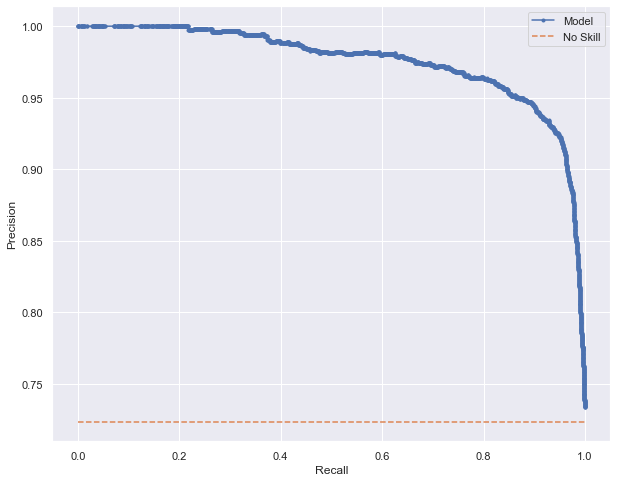




ROC AUC=0.944 



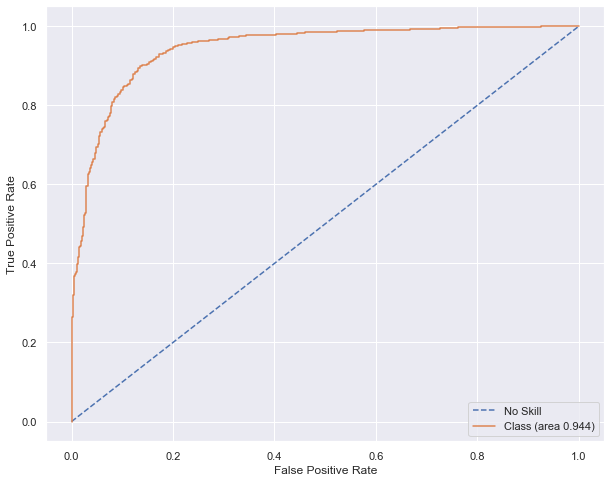


Evaluation Curves


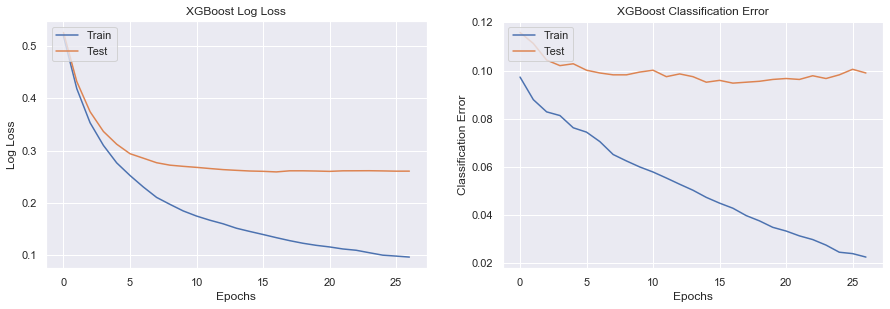



Cohen's kappa: 75.42%




In [78]:
print(f"\nThe precision of the model is {round(100*precision_score(valid_y_sw, pred, labels),2)}%")
Metric.precision_recall_curve(xgbs,  xvalid_tfidf, valid_y,  labels,gb=True)
print("\n")
Metric.roc_auc_curve(xgbs,  xvalid_tfidf, valid_y, labels, gb=True)
print("\nEvaluation Curves")
Metric.plot_eval_xgb(xgbs, labels)
print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_tfidf)),2)}%\n\n")

<i><h3>XGBoost for TF-IDF ngram </h3></i>


XGBoost for TF_IDF ngram



C:\Users\tabbe\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Accuracy: 90.91%

Classification Report

              precision    recall  f1-score   support

    negative       0.88      0.78      0.82       723
    positive       0.92      0.96      0.94      1894

    accuracy                           0.91      2617
   macro avg       0.90      0.87      0.88      2617
weighted avg       0.91      0.91      0.91      2617


Confusion Matrix



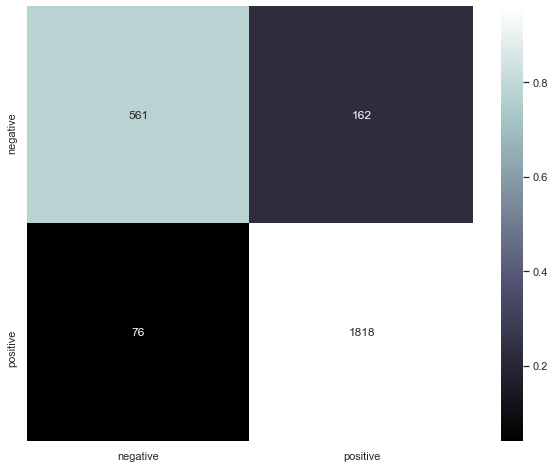

In [79]:
print("\nXGBoost for TF_IDF ngram\n")
xgbs, pred, accuracy = xgb_model(xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, labels=labels)
print("\nClassification Report\n")
print(classification_report(valid_y, pred, target_names=labels))
cm = confusion_matrix(valid_y, pred)
print("\nConfusion Matrix\n")
Metric.plot_confusion_matrix(cm, labels)


The precision of the model is 91.82%


Model: f1-score=0.939 AUC=0.977




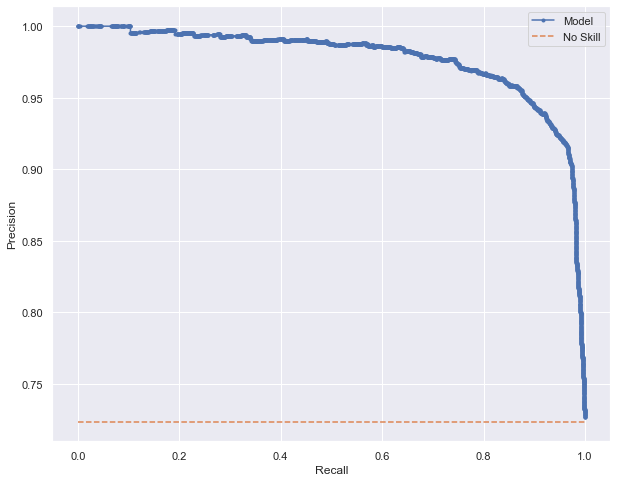




ROC AUC=0.948 



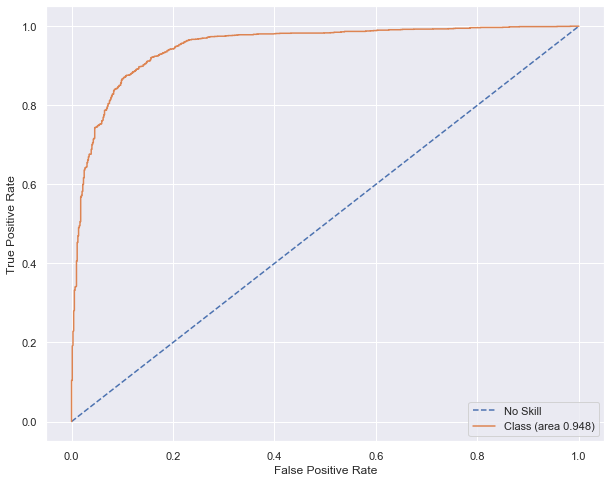


Evaluation Curves


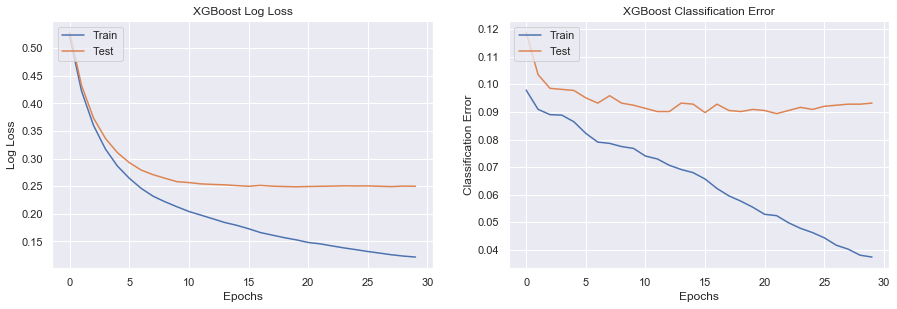



Cohen's kappa: 76.39%




In [80]:
print(f"\nThe precision of the model is {round(100*precision_score(valid_y, pred, labels),2)}%")
Metric.precision_recall_curve(xgbs,  xvalid_tfidf_ngram, valid_y, labels, gb=True)
print("\n")
Metric.roc_auc_curve(xgbs,  xvalid_tfidf_ngram, valid_y, labels, gb=True)
print("\nEvaluation Curves")
Metric.plot_eval_xgb(xgbs,  labels)
print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_tfidf_ngram)),2)}%\n\n")

<i><h3>XGBoost for TF-IDF ngram chars</h3></i>


XGBoost for TF-IDF ngram chars



C:\Users\tabbe\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Accuracy: 88.88%

Classification Report

              precision    recall  f1-score   support

    negative       0.85      0.72      0.78       723
    positive       0.90      0.95      0.93      1894

    accuracy                           0.89      2617
   macro avg       0.88      0.84      0.85      2617
weighted avg       0.89      0.89      0.89      2617


Confusion Matrix



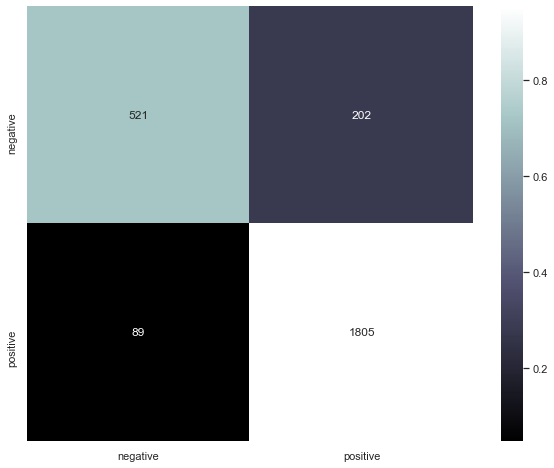

In [81]:
print("\nXGBoost for TF-IDF ngram chars\n")
xgbs, pred, accuracy = xgb_model(xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, labels=labels)
print("\nClassification Report\n")
print(classification_report(valid_y, pred,target_names=labels))
cm = confusion_matrix(valid_y, pred)
print("\nConfusion Matrix\n")
Metric.plot_confusion_matrix(cm, labels)


The precision of the model is 89.94%


Model: f1-score=0.925 AUC=0.971




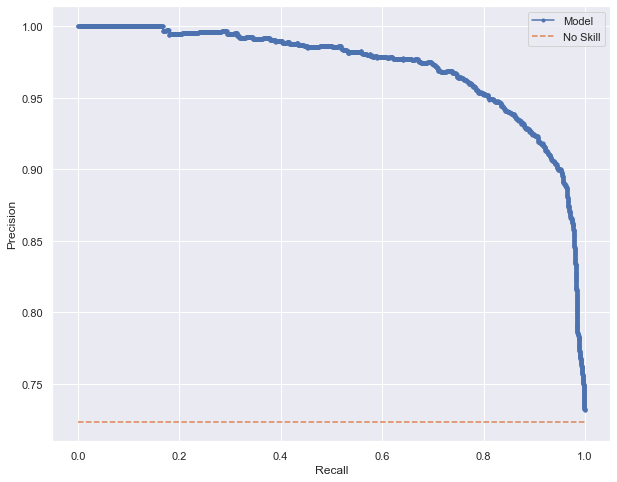




ROC AUC=0.932 



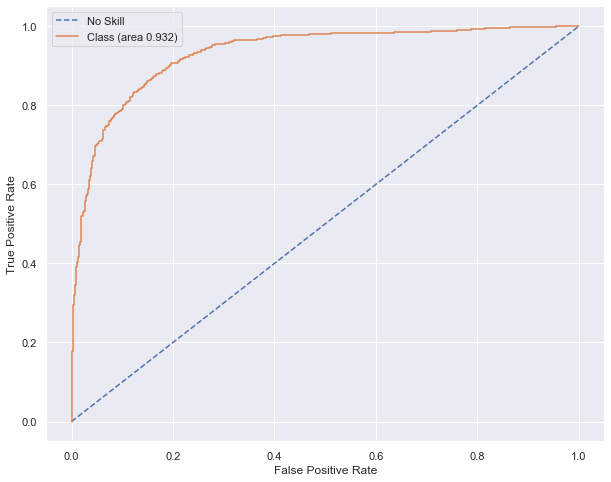


Evaluation Curves


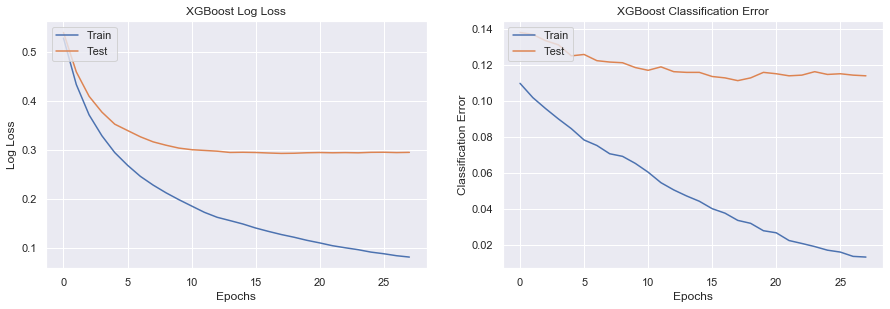



Cohen's kappa: 70.78%




In [82]:
print(f"\nThe precision of the model is {round(100*precision_score(valid_y, pred, labels),2)}%")
Metric.precision_recall_curve(xgbs,  xvalid_tfidf_ngram_chars, valid_y, labels, gb=True)
print("\n")
Metric.roc_auc_curve(xgbs,  xvalid_tfidf_ngram_chars, valid_y, labels, gb=True)
print("\nEvaluation Curves")
Metric.plot_eval_xgb(xgbs,  labels)
print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_tfidf_ngram_chars)),2)}%\n\n")

<i><h3>XGBoost for Word Embeddings</h3></i>


XGBoost for Word Embeddings



C:\Users\tabbe\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Accuracy: 72.53%

Classification Report

              precision    recall  f1-score   support

    negative       0.51      0.14      0.22       723
    positive       0.74      0.95      0.83      1894

    accuracy                           0.73      2617
   macro avg       0.63      0.54      0.53      2617
weighted avg       0.68      0.73      0.66      2617


Confusion Matrix



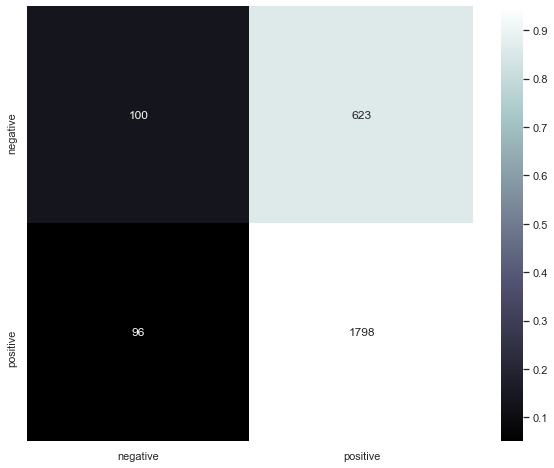

In [83]:
print("\nXGBoost for Word Embeddings\n")
xgbs, pred, accuracy = xgb_model(train_seq_x, train_y, valid_seq_x, valid_y, labels=labels)
print("\nClassification Report\n")
print(classification_report(valid_y, pred, target_names=labels))
cm = confusion_matrix(valid_y, pred)
print("\nConfusion Matrix\n")
Metric.plot_confusion_matrix(cm, labels)


The accuracy of the model is 72.53%


Model: f1-score=0.833 AUC=0.842




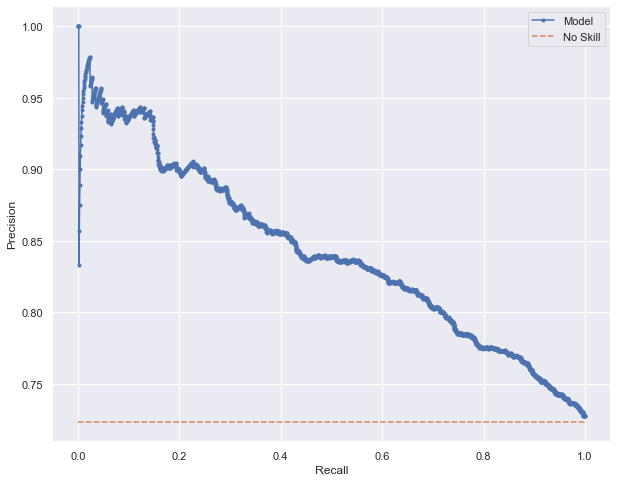




ROC AUC=0.679 



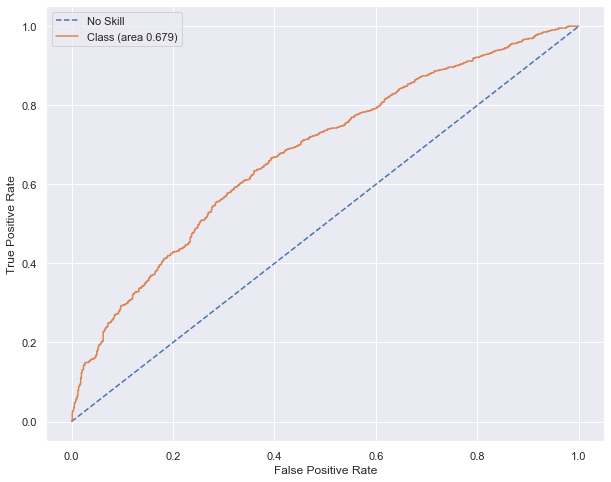


Evaluation Curves


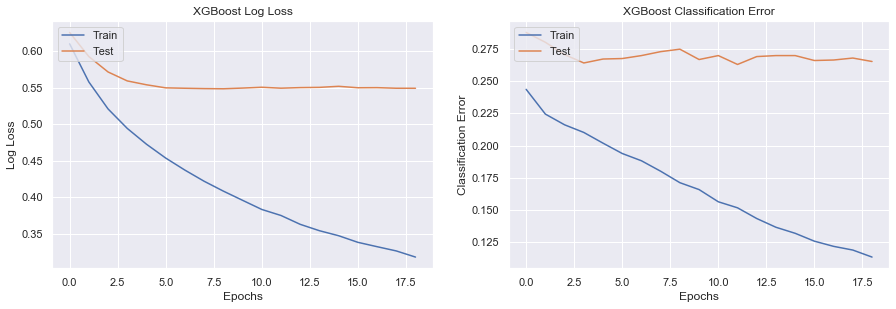



Cohen's kappa: 11.31%




In [84]:
print(f"\nThe accuracy of the model is {round(100*accuracy_score(valid_y, pred, labels),2)}%")
Metric.precision_recall_curve(xgbs,  valid_seq_x, valid_y, labels, gb=True)
print("\n")
Metric.roc_auc_curve(xgbs,  valid_seq_x, valid_y, labels, gb=True)
print("\nEvaluation Curves")
Metric.plot_eval_xgb(xgbs,  labels)
print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(valid_seq_x)),2)}%\n\n")

In [ ]:
#Deep learning models

In [85]:
pre_trained = pretrained

In [86]:
#code for confusion matrix
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

---

In [87]:
#define early Stopping, Model saving, Class weight configuration
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
check_p = tf.keras.callbacks.ModelCheckpoint("save_models/model.h5", save_best_only=True)

In [88]:
class_w = {}
for i in zip(range(len(class_weights)), class_weights):
    class_w[i[0]] = i[1]

In [89]:
#shallow NN

In [90]:
def shallow_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=True):
    '''
    Function to generate a shallow neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) shallow neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 16)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      
      keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'], weighted_metrics=["balanced_accuracy"])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [91]:
model_shallow = shallow_neural_networks(word_index, pre_trained=pre_trained)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         49631700  
_________________________________________________________________
global_average_pooling1d (Gl (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 49,632,001
Trainable params: 301
Non-trainable params: 49,631,700
_________________________________________________________________
None


In [92]:
history = model_shallow.fit(train_seq_x, train_y,
                epochs=1000, callbacks=[es],
                validation_split=0.2, verbose=True)#, class_weight=class_w)

Train on 8372 samples, validate on 2093 samples
Epoch 1/1000
8372/8372 [==============================] - 2s 209us/sample - loss: 0.5994 - acc: 0.7107 - weighted_acc: 0.7107 - val_loss: 0.5992 - val_acc: 0.7215 - val_weighted_acc: 0.7215
Epoch 2/1000
8372/8372 [==============================] - 2s 194us/sample - loss: 0.5882 - acc: 0.7322 - weighted_acc: 0.7322 - val_loss: 0.5936 - val_acc: 0.7215 - val_weighted_acc: 0.7215
Epoch 3/1000
8372/8372 [==============================] - 2s 197us/sample - loss: 0.5838 - acc: 0.7322 - weighted_acc: 0.7322 - val_loss: 0.5914 - val_acc: 0.7215 - val_weighted_acc: 0.7215
Epoch 4/1000
8372/8372 [==============================] - 2s 210us/sample - loss: 0.5818 - acc: 0.7322 - weighted_acc: 0.7322 - val_loss: 0.5903 - val_acc: 0.7215 - val_weighted_acc: 0.7215
Epoch 5/1000
8372/8372 [==============================] - 2s 202us/sample - loss: 0.5807 - acc: 0.7322 - weighted_acc: 0.7322 - val_loss: 0.5897 - val_acc: 0.7215 - val_weighted_acc: 0.7215
Ep

In [93]:
results = model_shallow.evaluate(valid_seq_x, valid_y)
print(results)
print(f"\nThe accuracy of the model is {round(100*accuracy_score(valid_y, (model_shallow.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

2617/2617 [==============================] - 0s 148us/sample - loss: 0.5382 - acc: 0.7837 - weighted_acc: 0.7837
[0.5381834984258427, 0.7837218, 0.7837218]

The accuracy of the model is 78.37%


In [94]:
print(results)
cm = confusion_matrix(y_true=valid_y, y_pred=(model_shallow.predict(valid_seq_x)>0.5).astype(int))

[0.5381834984258427, 0.7837218, 0.7837218]



ROC AUC=0.806 



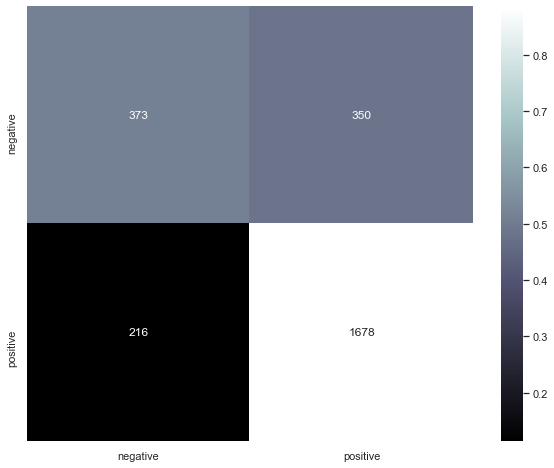

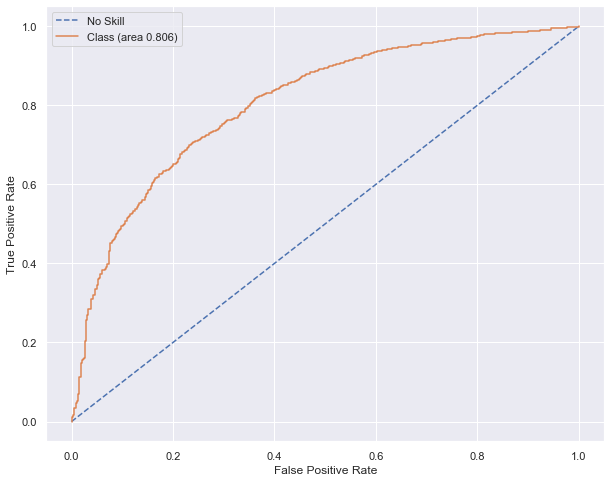

In [148]:
cm = confusion_matrix(y_true=valid_y, y_pred=(model_shallow.predict(valid_seq_x)>0.5).astype(int))
Metric.plot_confusion_matrix(cm, labels)
Metric.roc_auc_curve(model_shallow, valid_seq_x, valid_y,  labels)

In [95]:
#Deep NN

In [149]:
def deep_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=True):
    '''
    Function to generate a deep neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) deep neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [150]:
model = deep_neural_networks(word_index, pre_trained=pre_trained)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 300)         49631700  
_________________________________________________________________
global_average_pooling1d_4 ( (None, 300)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)                4816      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total params: 49,636,533
Trainable params: 4,833
Non-trainable params: 49,631,700
_________________________________________________________________
None


In [151]:
history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)#, class_weight=class_w)

Train on 8372 samples, validate on 2093 samples
Epoch 1/1000
8372/8372 [==============================] - 2s 291us/sample - loss: 0.5927 - acc: 0.7238 - val_loss: 0.5916 - val_acc: 0.7215
Epoch 2/1000
8372/8372 [==============================] - 2s 203us/sample - loss: 0.5800 - acc: 0.7322 - val_loss: 0.5869 - val_acc: 0.7215
Epoch 3/1000
8372/8372 [==============================] - 2s 208us/sample - loss: 0.5757 - acc: 0.7321 - val_loss: 0.5829 - val_acc: 0.7224
Epoch 4/1000
8372/8372 [==============================] - 2s 204us/sample - loss: 0.5713 - acc: 0.7317 - val_loss: 0.5791 - val_acc: 0.7224
Epoch 5/1000
8372/8372 [==============================] - 2s 208us/sample - loss: 0.5673 - acc: 0.7298 - val_loss: 0.5752 - val_acc: 0.7167
Epoch 6/1000
8372/8372 [==============================] - 2s 208us/sample - loss: 0.5638 - acc: 0.7226 - val_loss: 0.5732 - val_acc: 0.7191
Epoch 7/1000
8372/8372 [==============================] - 2s 208us/sample - loss: 0.5614 - acc: 0.7224 - val_los

In [152]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)
print(f"\nThe accuracy of the model is {round(100*accuracy_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

2617/2617 [==============================] - 0s 159us/sample - loss: 0.5268 - acc: 0.7914
[0.5268282146457501, 0.79136413]

The accuracy of the model is 79.14%



ROC AUC=0.813 



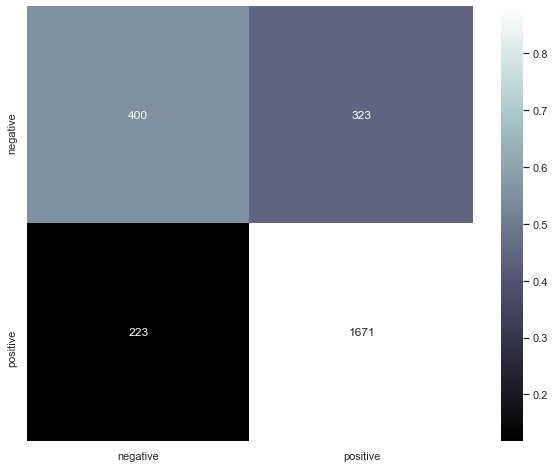

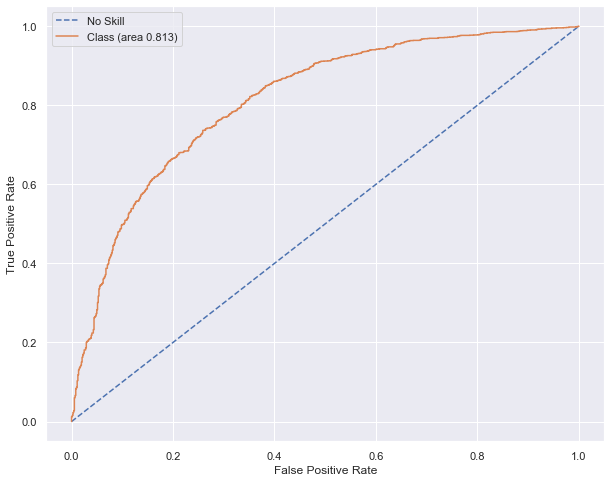

In [155]:
cm = confusion_matrix(y_true=valid_y, y_pred=(model.predict(valid_seq_x)>0.5).astype(int))
Metric.plot_confusion_matrix(cm, labels)
Metric.roc_auc_curve(model, valid_seq_x, valid_y,  labels)

In [156]:
#deep nn variation1

In [157]:
def deep_neural_networks_var1(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=True):
    '''
    Function to generate a deep neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) deep neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1  if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [158]:
model = deep_neural_networks_var1(word_index, pre_trained=pre_trained)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 300)         49631700  
_________________________________________________________________
global_average_pooling1d_5 ( (None, 300)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                4816      
_________________________________________________________________
dense_20 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total params: 49,636,805
Trainable params: 5,105
Non-trainable params: 49,631,700
_________________________________________________________________
None


In [159]:
history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)

Train on 8372 samples, validate on 2093 samples
Epoch 1/1000
8372/8372 [==============================] - 2s 295us/sample - loss: 0.5898 - acc: 0.7254 - val_loss: 0.5897 - val_acc: 0.7215
Epoch 2/1000
8372/8372 [==============================] - 2s 204us/sample - loss: 0.5767 - acc: 0.7322 - val_loss: 0.5818 - val_acc: 0.7224
Epoch 3/1000
8372/8372 [==============================] - 2s 203us/sample - loss: 0.5682 - acc: 0.7311 - val_loss: 0.5741 - val_acc: 0.7157
Epoch 4/1000
8372/8372 [==============================] - 2s 203us/sample - loss: 0.5610 - acc: 0.7191 - val_loss: 0.5687 - val_acc: 0.7138
Epoch 5/1000
8372/8372 [==============================] - 2s 203us/sample - loss: 0.5557 - acc: 0.7254 - val_loss: 0.5644 - val_acc: 0.7238
Epoch 6/1000
8372/8372 [==============================] - 2s 204us/sample - loss: 0.5514 - acc: 0.7314 - val_loss: 0.5587 - val_acc: 0.7138
Epoch 7/1000
8372/8372 [==============================] - 2s 212us/sample - loss: 0.5467 - acc: 0.7403 - val_los

In [160]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)
print(f"\nThe accuracy of the model is {round(100*accuracy_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

2617/2617 [==============================] - 0s 162us/sample - loss: 0.5316 - acc: 0.7929
[0.5316455108795086, 0.79289263]

The accuracy of the model is 79.29%



ROC AUC=0.808 



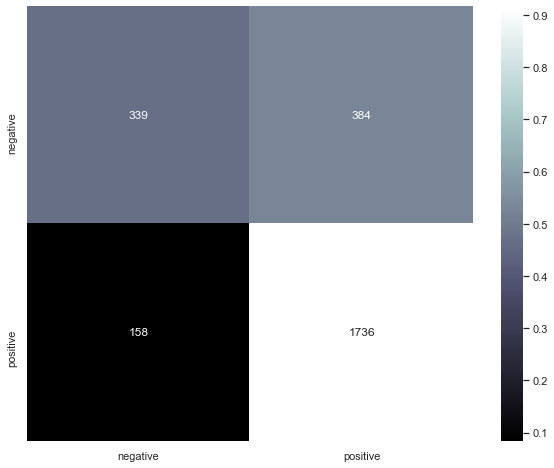

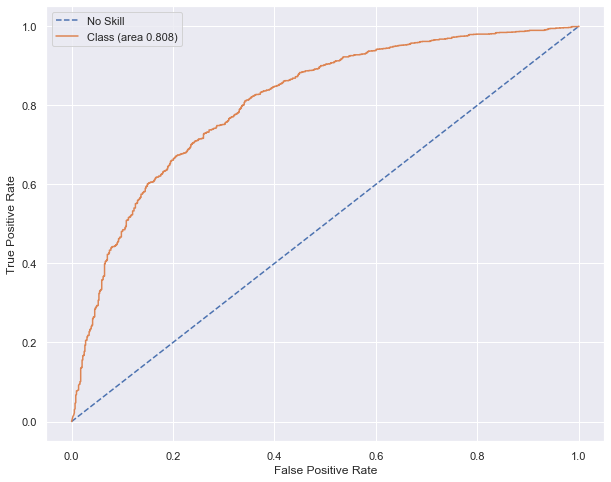

In [161]:
cm = confusion_matrix(y_true=valid_y, y_pred=(model.predict(valid_seq_x)>0.5).astype(int))
Metric.plot_confusion_matrix(cm, labels)
Metric.roc_auc_curve(model, valid_seq_x, valid_y,  labels)

In [105]:
#deep nn variation2

In [162]:
def deep_neural_networks_var2(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=True):
    '''
    Function to generate a deep neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) deep neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1  if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model


In [163]:
model = deep_neural_networks_var2(word_index, pre_trained=pre_trained)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 300)         49631700  
_________________________________________________________________
global_average_pooling1d_6 ( (None, 300)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                9632      
_________________________________________________________________
dense_23 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 17        
Total params: 49,641,877
Trainable params: 10,177
Non-trainable params: 49,631,700
_________________________________________________________________
None


In [164]:
history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)

Train on 8372 samples, validate on 2093 samples
Epoch 1/1000
8372/8372 [==============================] - 3s 300us/sample - loss: 0.5837 - acc: 0.7322 - val_loss: 0.5877 - val_acc: 0.7215
Epoch 2/1000
8372/8372 [==============================] - 2s 216us/sample - loss: 0.5752 - acc: 0.7322 - val_loss: 0.5808 - val_acc: 0.7215
Epoch 3/1000
8372/8372 [==============================] - 2s 242us/sample - loss: 0.5679 - acc: 0.7228 - val_loss: 0.5735 - val_acc: 0.7043
Epoch 4/1000
8372/8372 [==============================] - 2s 224us/sample - loss: 0.5601 - acc: 0.7158 - val_loss: 0.5674 - val_acc: 0.7172
Epoch 5/1000
8372/8372 [==============================] - 2s 217us/sample - loss: 0.5534 - acc: 0.7305 - val_loss: 0.5613 - val_acc: 0.7296
Epoch 6/1000
8372/8372 [==============================] - 2s 210us/sample - loss: 0.5473 - acc: 0.7402 - val_loss: 0.5526 - val_acc: 0.7315
Epoch 7/1000
8372/8372 [==============================] - 2s 208us/sample - loss: 0.5411 - acc: 0.7483 - val_los

In [165]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)
print(f"\nThe accuracy of the model is {round(100*accuracy_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

2617/2617 [==============================] - 0s 155us/sample - loss: 0.5263 - acc: 0.7914
[0.5262676539838337, 0.79136413]

The accuracy of the model is 79.14%



ROC AUC=0.812 



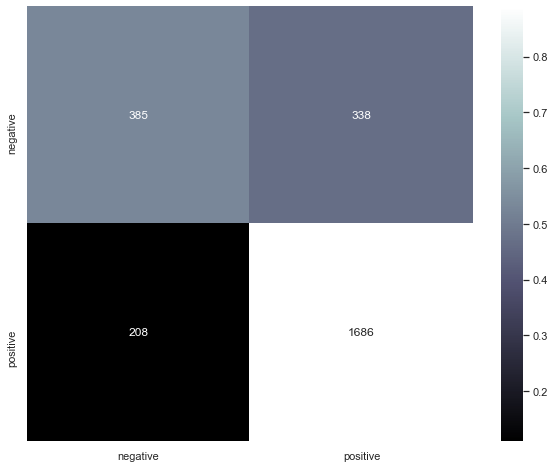

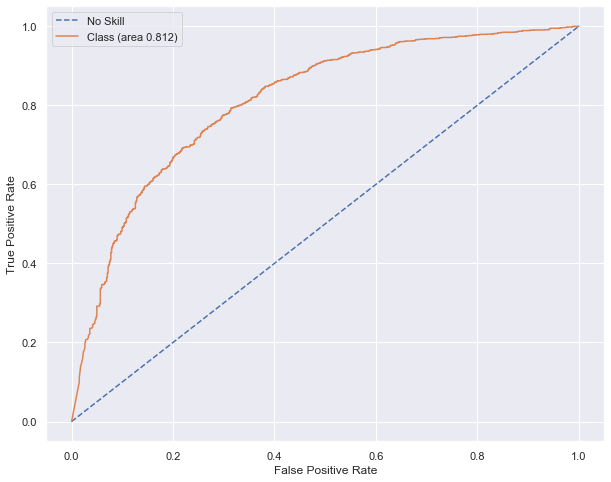

In [166]:
cm = confusion_matrix(y_true=valid_y, y_pred=(model.predict(valid_seq_x)>0.5).astype(int))
Metric.plot_confusion_matrix(cm, labels)
Metric.roc_auc_curve(model, valid_seq_x, valid_y,  labels)

In [167]:
#RNN

In [168]:
def create_rnn_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=True):
    '''
    Function to generate a recurrent neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) recurrent neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [169]:
model = create_rnn_model(word_index, pre_trained=pre_trained )

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 300)         49631700  
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, None, 32)          10656     
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 32)                2080      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 33        
Total params: 49,648,629
Trainable params: 16,929
Non-trainable params: 49,631,700
____________________________________

In [170]:
history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)#, class_weight=class_w)

Train on 8372 samples, validate on 2093 samples
Epoch 1/1000
8372/8372 [==============================] - 37s 4ms/sample - loss: 0.5773 - acc: 0.7229 - val_loss: 0.6027 - val_acc: 0.5743
Epoch 2/1000
8372/8372 [==============================] - 36s 4ms/sample - loss: 0.5664 - acc: 0.7241 - val_loss: 0.5838 - val_acc: 0.7296
Epoch 3/1000
8372/8372 [==============================] - 37s 4ms/sample - loss: 0.5660 - acc: 0.7438 - val_loss: 0.5717 - val_acc: 0.7444
Epoch 4/1000
8372/8372 [==============================] - 37s 4ms/sample - loss: 0.5573 - acc: 0.7443 - val_loss: 0.5667 - val_acc: 0.7133
Epoch 5/1000
8372/8372 [==============================] - 36s 4ms/sample - loss: 0.5771 - acc: 0.7143 - val_loss: 0.5762 - val_acc: 0.7229
Epoch 6/1000
8372/8372 [==============================] - 36s 4ms/sample - loss: 0.5606 - acc: 0.7260 - val_loss: 0.5642 - val_acc: 0.7162
Epoch 7/1000
8372/8372 [==============================] - 36s 4ms/sample - loss: 0.5535 - acc: 0.7370 - val_loss: 0.56

In [171]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)
print(f"\nThe accuracy of the model is {round(100*accuracy_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

2617/2617 [==============================] - 4s 2ms/sample - loss: 0.5573 - acc: 0.7065
[0.5573098098316127, 0.7065342]

The accuracy of the model is 70.65%



ROC AUC=0.698 



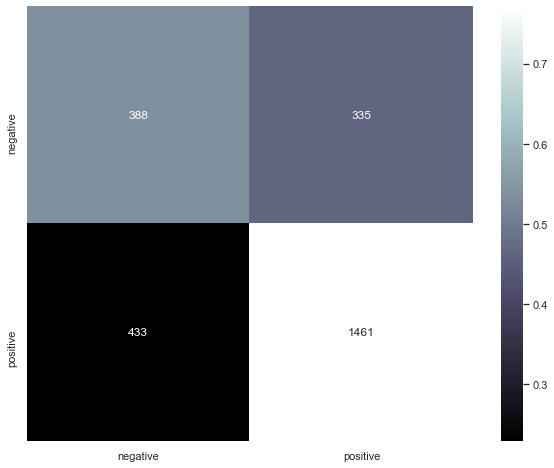

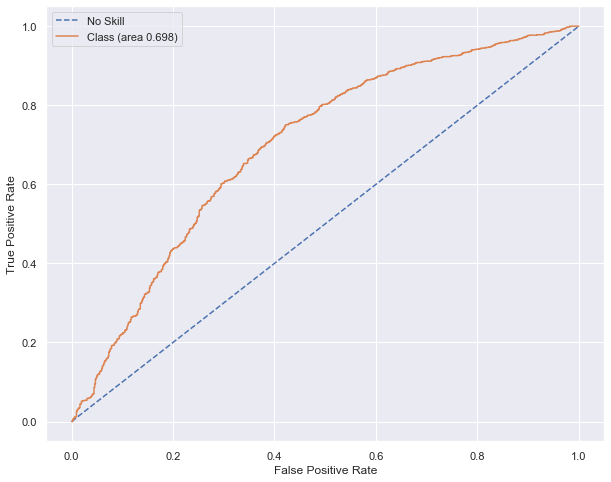

In [172]:
cm = confusion_matrix(y_true=valid_y, y_pred=(model.predict(valid_seq_x)>0.5).astype(int))
Metric.plot_confusion_matrix(cm, labels)
Metric.roc_auc_curve(model, valid_seq_x, valid_y,  labels)

In [115]:
#CNN

In [173]:
def create_conv_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=True):
    '''
    Function to generate a convulational neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) convulational neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) +1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(100, 5, activation='relu'), # padding='same'
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Conv1D(64, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Conv1D(32, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.GlobalMaxPooling1D(),

    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return model

In [174]:
model = create_conv_model(word_index, labels, pre_trained=pre_trained)

In [175]:
history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Train on 8372 samples, validate on 2093 samples
Epoch 1/50
8372/8372 [==============================] - 18s 2ms/sample - loss: 0.5809 - acc: 0.7317 - val_loss: 0.5871 - val_acc: 0.7215
Epoch 2/50
8372/8372 [==============================] - 16s 2ms/sample - loss: 0.5686 - acc: 0.7338 - val_loss: 0.5756 - val_acc: 0.7191
Epoch 3/50
8372/8372 [==============================] - 17s 2ms/sample - loss: 0.5534 - acc: 0.7346 - val_loss: 0.5610 - val_acc: 0.7520
Epoch 4/50
8372/8372 [==============================] - 18s 2ms/sample - loss: 0.5407 - acc: 0.7525 - val_loss: 0.5496 - val_acc: 0.7664
Epoch 5/50
8372/8372 [==============================] - 17s 2ms/sample - loss: 0.5316 - acc: 0.7703 - val_loss: 0.5427 - val_acc: 0.7912
Epoch 6/50
8372/8372 [==============================] - 17s 2ms/sample - loss: 0.5257 - acc: 0.7877 - val_loss: 0.5460 - val_acc: 0.7243
Epoch 7/50
8372/8372 [==============================] - 17s 2ms/sample - loss: 0.5210 - acc: 0.7923 - val_loss: 0.5330 - val_acc: 

In [176]:
results = model.evaluate(valid_seq_x, valid_y)
print(results)
print(f"\nThe accuracy of the model is {round(100*accuracy_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

2617/2617 [==============================] - 1s 466us/sample - loss: 0.5260 - acc: 0.8089s - loss: 0.5278
[0.5260051581232794, 0.80894154]

The accuracy of the model is 80.89%



ROC AUC=0.828 



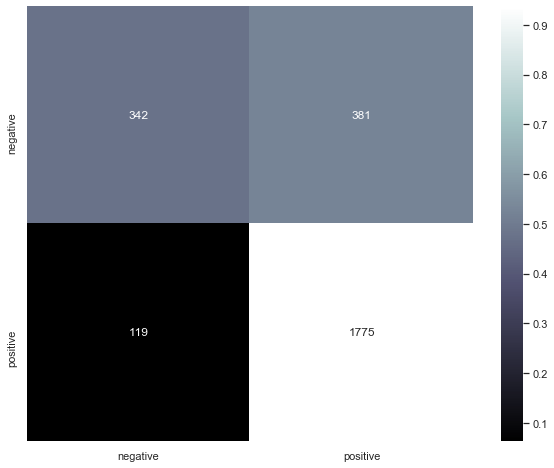

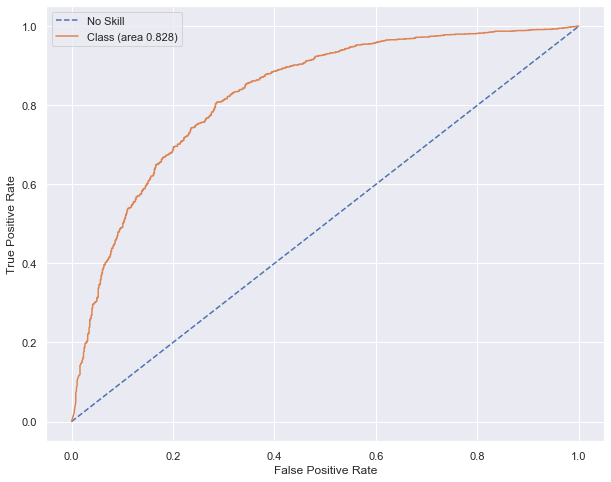

In [177]:
cm = confusion_matrix(y_true=valid_y, y_pred=(model.predict(valid_seq_x)>0.5).astype(int))
Metric.plot_confusion_matrix(cm, labels)
Metric.roc_auc_curve(model, valid_seq_x, valid_y,  labels)

In [178]:
#RNN-LSTM

In [179]:
def create_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=True):
    '''
    Function to generate a lstm for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) lstm 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) +1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index)+1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.LSTM(32),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [180]:
model = create_lstm_model(word_index, pre_trained=pre_trained)

history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 300)         49631700  
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 49,674,357
Trainable params: 42,657
Non-trainable params: 49,631,700
_________________________________________________________________
None
Train on 8372 samples, validate on 2093 samples
Epoch 1/50
8372/8372 [==============================] - 38s 5ms/sample - loss: 0.5734 - acc: 0.7222 - val_loss: 0.5842 - val_acc: 0.7286
Epoch 2/50
8372/8372 [======================

In [181]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)
print(f"\nThe accuracy of the model is {round(100*accuracy_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

2617/2617 [==============================] - 4s 1ms/sample - loss: 0.5751 - acc: 0.7367
[0.5750551383414249, 0.73672146]

The accuracy of the model is 73.67%



ROC AUC=0.656 



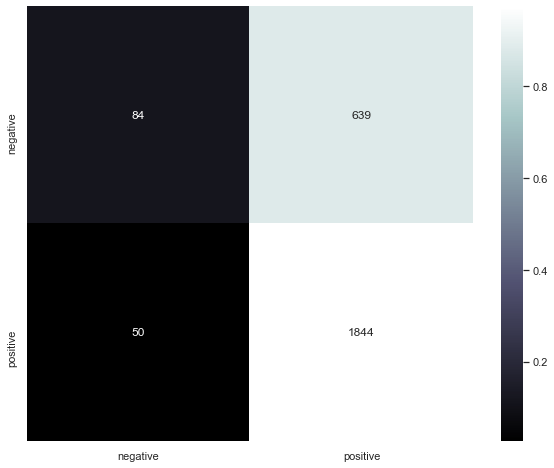

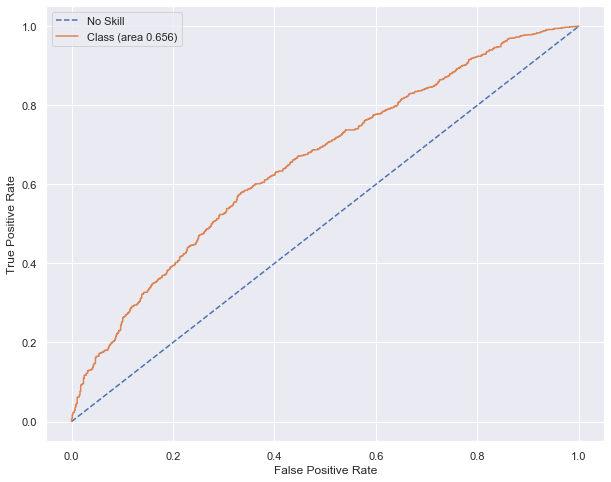

In [182]:
cm = confusion_matrix(y_true=valid_y, y_pred=(model.predict(valid_seq_x)>0.5).astype(int))
Metric.plot_confusion_matrix(cm, labels)
Metric.roc_auc_curve(model, valid_seq_x, valid_y,  labels)

In [183]:
#CNN-LSTM

In [184]:
def create_cnn_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=True):
    '''
    Function to generate a convulational neural network lstm for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) convulational neural network lstm
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.LSTM(32),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [185]:
model = create_cnn_lstm_model(word_index, pre_trained=pre_trained)

history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 300)         49631700  
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 128)         192128    
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 33        
Total params: 49,844,469
Trainable params: 212,769
Non-trainable params: 49,631,700
___________________________________

In [186]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)
print(f"\nThe accuracy of the model is {round(100*accuracy_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

2617/2617 [==============================] - 2s 663us/sample - loss: 0.5229 - acc: 0.7975
[0.5229494384125895, 0.797478]

The accuracy of the model is 79.75%



ROC AUC=0.815 



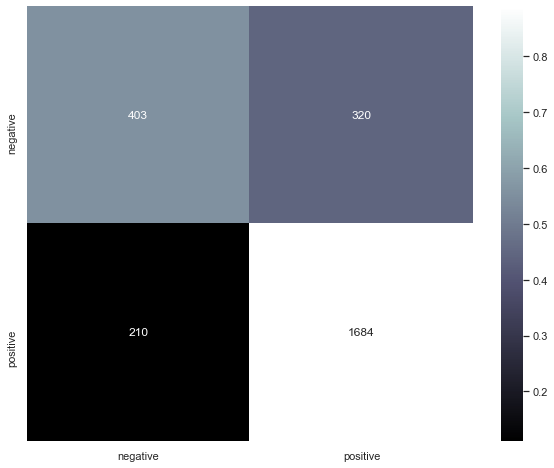

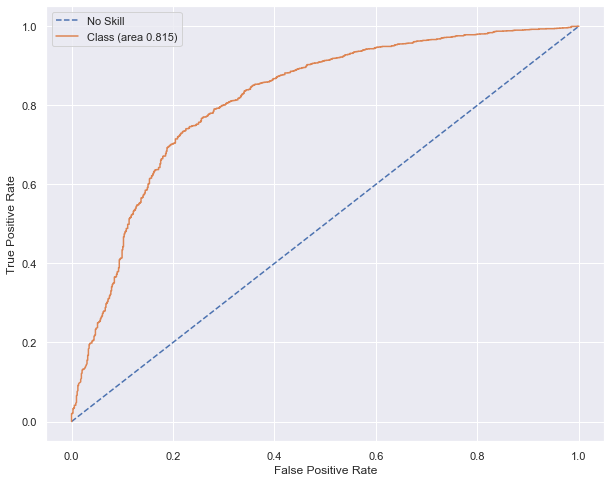

In [187]:
cm = confusion_matrix(y_true=valid_y, y_pred=(model.predict(valid_seq_x)>0.5).astype(int))
Metric.plot_confusion_matrix(cm, labels)
Metric.roc_auc_curve(model, valid_seq_x, valid_y,  labels)

In [188]:
#CNN-GRU

In [189]:
def create_cnn_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=True):
    '''
    Function to generate a convulational neural network GRU for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) convulational neural network GRU
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.GRU(32),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [190]:
model = create_cnn_gru_model(word_index, pre_trained=pre_trained)
history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 300)         49631700  
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 128)         192128    
_________________________________________________________________
dropout_14 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                15456     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total params: 49,839,317
Trainable params: 207,617
Non-trainable params: 49,631,700
___________________________________

In [191]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)
print(f"\nThe accuracy of the model is {round(100*accuracy_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

2617/2617 [==============================] - 2s 603us/sample - loss: 0.5225 - acc: 0.7990
[0.5224869281998745, 0.7990065]

The accuracy of the model is 79.9%



ROC AUC=0.819 



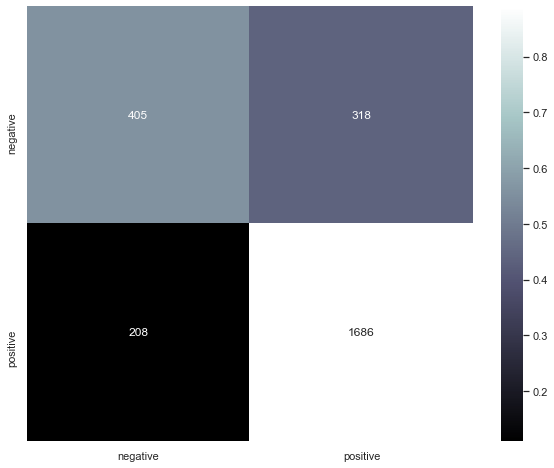

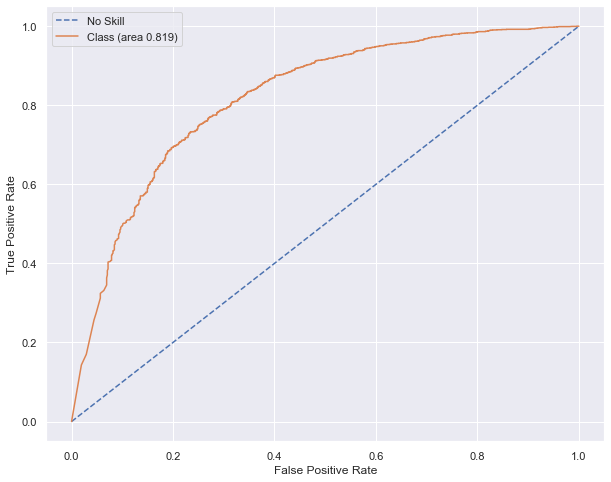

In [192]:
cm = confusion_matrix(y_true=valid_y, y_pred=(model.predict(valid_seq_x)>0.5).astype(int))
Metric.plot_confusion_matrix(cm, labels)
Metric.roc_auc_curve(model, valid_seq_x, valid_y,  labels)

In [193]:
#RNN-GRU

In [194]:
def create_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=True):
    '''
    Function to generate a gru for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) gru 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.GRU(32),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [195]:
model = create_gru_model(word_index, pre_trained=pre_trained )


history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 300)         49631700  
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                31968     
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 33        
Total params: 49,663,701
Trainable params: 32,001
Non-trainable params: 49,631,700
_________________________________________________________________
None
Train on 8372 samples, validate on 2093 samples
Epoch 1/50
8372/8372 [==============================] - 37s 4ms/sample - loss: 0.5765 - acc: 0.7204 - val_loss: 0.5813 - val_acc: 0.7296
Epoch 2/50
8372/8372 [======================

In [196]:
results = model.evaluate(valid_seq_x, valid_y)
print(results)
print(f"\nThe accuracy of the model is {round(100*accuracy_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

2617/2617 [==============================] - 4s 2ms/sample - loss: 0.5842 - acc: 0.7237
[0.5842391307179965, 0.72372943]

The accuracy of the model is 72.37%



ROC AUC=0.649 



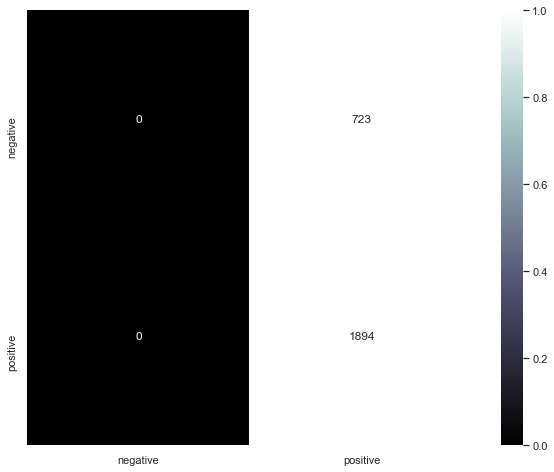

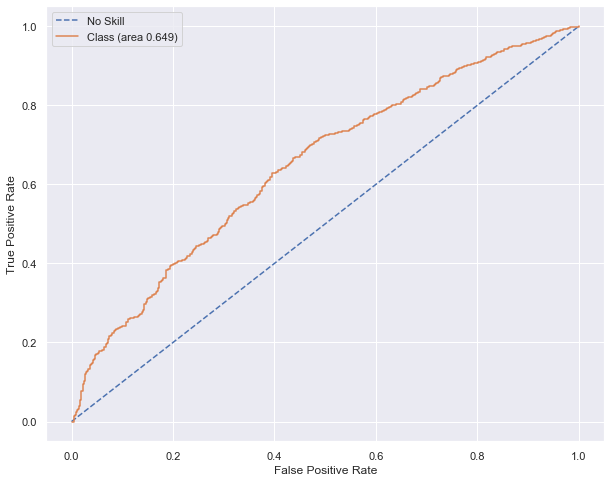

In [197]:
cm = confusion_matrix(y_true=valid_y, y_pred=(model.predict(valid_seq_x)>0.5).astype(int))
Metric.plot_confusion_matrix(cm, labels)
Metric.roc_auc_curve(model, valid_seq_x, valid_y,  labels)

In [198]:
#BidirectionalRNN

In [199]:
def create_bidirec_rnn_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=True):
    '''
    Function to generate a bidirectional rnn for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) bidirectional rnn
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [200]:
model = create_bidirec_rnn_model(word_index, pre_trained=pre_trained)
    
history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 300)         49631700  
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 64)          21312     
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 64)          6208      
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 64)          6208      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                6208      
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)               

In [201]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)
print(f"\nThe accuracy of the model is {round(100*accuracy_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

2617/2617 [==============================] - 7s 3ms/sample - loss: 0.5704 - acc: 0.7249
[0.5704461126141663, 0.7248758]

The accuracy of the model is 72.49%



ROC AUC=0.677 



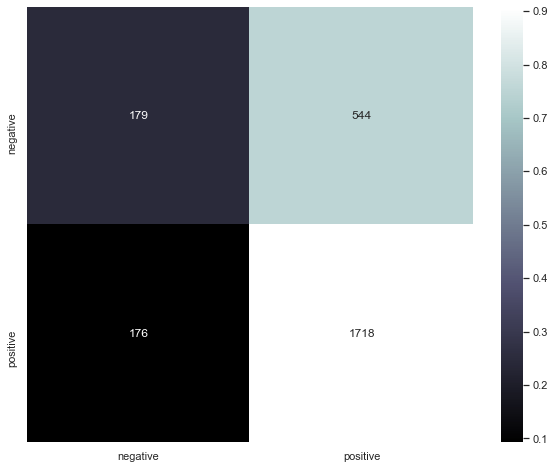

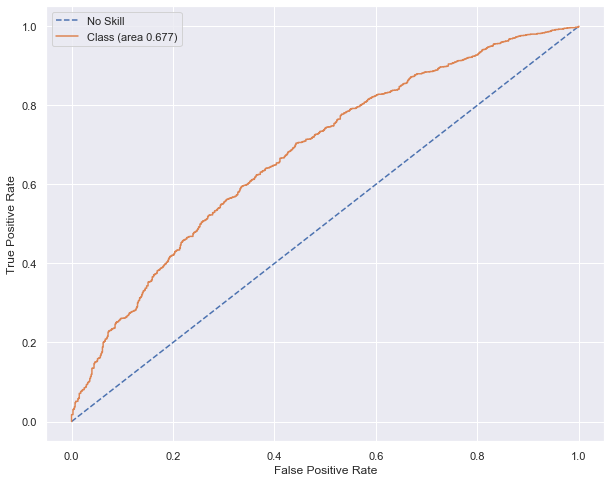

In [202]:
cm = confusion_matrix(y_true=valid_y, y_pred=(model.predict(valid_seq_x)>0.5).astype(int))
Metric.plot_confusion_matrix(cm, labels)
Metric.roc_auc_curve(model, valid_seq_x, valid_y,  labels)

In [203]:
#Bidirectional LSTM

In [204]:
def create_bidirec_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=True):
    '''
    Function to generate a bidirectional lstm for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) bidirectional lstm
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [205]:
model = create_bidirec_lstm_model(word_index, pre_trained=pre_trained)

history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 300)         49631700  
_________________________________________________________________
bidirectional_9 (Bidirection (None, 64)                85248     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 49,717,013
Trainable params: 85,313
Non-trainable params: 49,631,700
_________________________________________________________________
None
Train on 8372 samples, validate on 2093 samples
Epoch 1/50
8372/8372 [==============================] - 92s 11ms/sample - loss: 0.5747 - acc: 0.7291 - val_loss: 0.5724 - val_acc: 0.7057
Epoch 2/50
8372/8372 [=====================

In [206]:
results = model.evaluate(valid_seq_x, valid_y)

print(results)
print(f"\nThe accuracy of the model is {round(100*accuracy_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

2617/2617 [==============================] - 10s 4ms/sample - loss: 0.5853 - acc: 0.7291
[0.5852986327053984, 0.7290791]

The accuracy of the model is 72.91%



ROC AUC=0.496 



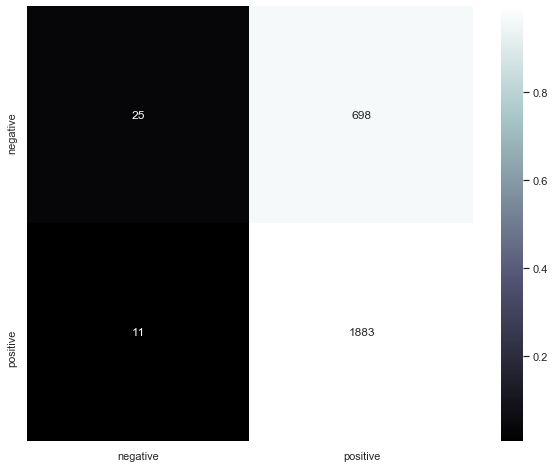

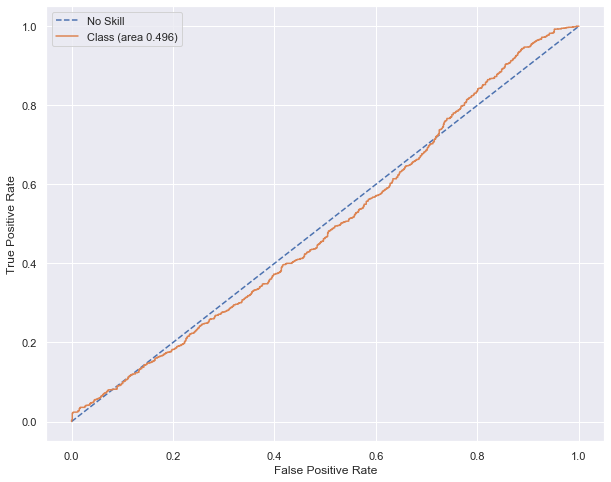

In [207]:
cm = confusion_matrix(y_true=valid_y, y_pred=(model.predict(valid_seq_x)>0.5).astype(int))
Metric.plot_confusion_matrix(cm, labels)
Metric.roc_auc_curve(model, valid_seq_x, valid_y,  labels)

In [208]:
#bidirectional GRU

In [209]:
def create_bidirec_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=True):
    '''
    Function to generate a bidirectional gru for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) bidirectional gru
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.GRU(32)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [210]:
model = create_bidirec_gru_model(word_index, pre_trained=pre_trained)

history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, None, 300)         49631700  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 64)                63936     
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 65        
Total params: 49,695,701
Trainable params: 64,001
Non-trainable params: 49,631,700
_________________________________________________________________
None
Train on 8372 samples, validate on 2093 samples
Epoch 1/50
8372/8372 [==============================] - 90s 11ms/sample - loss: 0.5805 - acc: 0.7226 - val_loss: 0.5916 - val_acc: 0.7215
Epoch 2/50
8372/8372 [=====================

In [211]:
results = model.evaluate(valid_seq_x, valid_y)
print(results)
print(f"\nThe accuracy of the model is {round(100*accuracy_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

2617/2617 [==============================] - 9s 4ms/sample - loss: 0.5788 - acc: 0.6714
[0.5788212681618363, 0.67137945]

The accuracy of the model is 67.14%



ROC AUC=0.687 



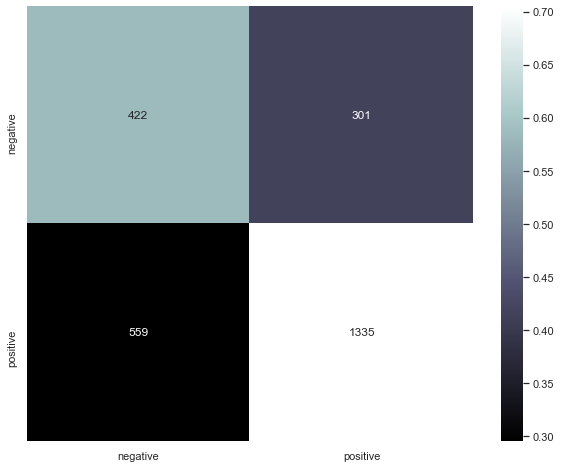

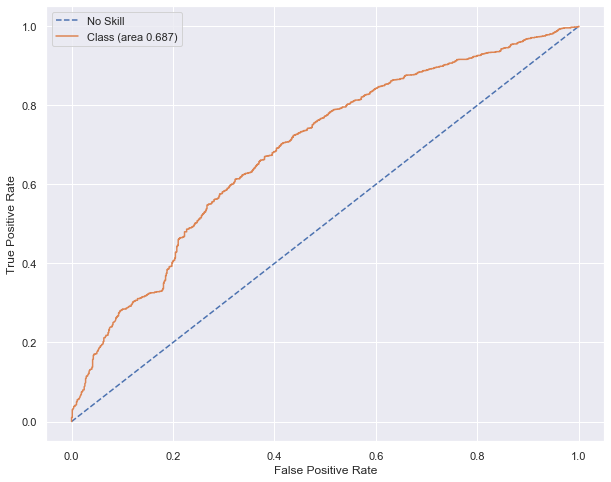

In [212]:
cm = confusion_matrix(y_true=valid_y, y_pred=(model.predict(valid_seq_x)>0.5).astype(int))
Metric.plot_confusion_matrix(cm, labels)
Metric.roc_auc_curve(model, valid_seq_x, valid_y,  labels)

In [213]:
#R-CNN

In [214]:
def create_rcnn(X, word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=True):
    '''
    Function to generate a rcnn for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model)  rcnn
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300,input_length=X.shape[1], weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(32,return_sequences=True)),
    keras.layers.Convolution1D(32, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(25, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [215]:
model = create_rcnn(train_seq_x, word_index,  pre_trained = pre_trained)


history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 300, 300)          49631700  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 300)          0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 300, 64)           63936     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 298, 32)           6176      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 25)                825       
_________________________________________________________________
dropout_19 (Dropout)         (None, 25)              

In [216]:
results = model.evaluate(valid_seq_x, valid_y)
print(results)
print(f"\nThe accuracy of the model is {round(100*accuracy_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

2617/2617 [==============================] - 11s 4ms/sample - loss: 0.5294 - acc: 0.7810
[0.5294474235553982, 0.781047]

The accuracy of the model is 78.1%



ROC AUC=0.764 



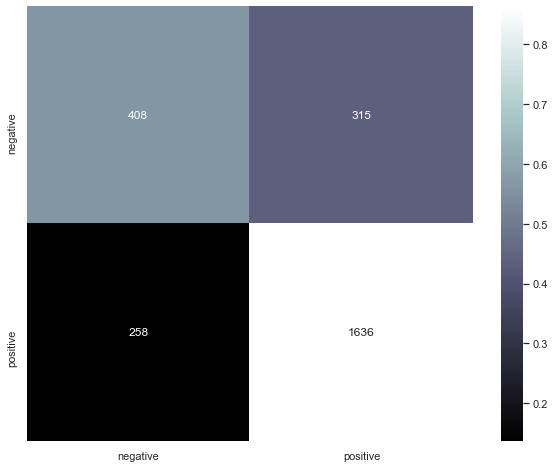

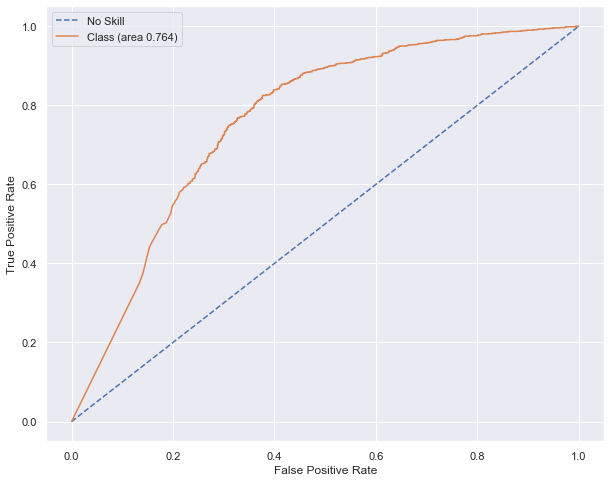

In [217]:
cm = confusion_matrix(y_true=valid_y, y_pred=(model.predict(valid_seq_x)>0.5).astype(int))
Metric.plot_confusion_matrix(cm, labels)
Metric.roc_auc_curve(model, valid_seq_x, valid_y,  labels)